# Table of contents
- [Cleaning](#Cleaning)
- [Analysis](#Analysis)
- [Clustering](#Clustering)
- [Insights](#Insights) 

In [107]:
#NECESSITIES 

import pandas as pd
#pd set option specified after the loading of the dataset
import seaborn as sns 
import numpy as np
from numpy.random import seed
seed(223)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False
import matplotlib.colors as colors
from datetime import datetime

#for the maps
import folium 
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd
from branca.element import Figure
from geopy.geocoders import Nominatim #converts an address into latitude and longitude values 
import osmnx as ox
from shapely.ops import transform
import pyproj
from shapely.geometry import Point, LineString, Polygon
import pyrosm
import contextily as cx
import graphviz

#for the models 
import sklearn.metrics
import graphviz
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score, r2_score

#to work with files 
import json
import os
import collections
import itertools
import sqlite3
import csv
import psycopg2
import time
import shapely
from shapely import wkb 
import spatialite 
import os.path
import pickle

#for the widgets
import ipywidgets as widgets
from ipywidgets import FileUpload
from ipywidgets import interactive

In [2]:
#PATH FOR THE DB 
DB_PATH = "./data/airbnb.db"
#alternatively code that I leave here just to remember  os.path.join(os.getcwd(), 'airbnb.db')

In [3]:
#GEOREFERENCE OF BOLOGNA
#I retrieve the latitude and longitude for the centroids
address = 'Bologna, Emilia Romagna, Italy'

geolocator = Nominatim(user_agent="isabella.dario@studenti.unit.it") #https://wiki.openstreetmap.org/wiki/Nominatim#Parameters
location = geolocator.geocode(address)                               #if it says user rate exceeded just change user agent (put your email or another email)

latitude = location.latitude     #these are used in the maps of this analysis
longitude = location.longitude

#print('The coordinates of Bologna are {}, {}.'.format(latitude, longitude))

# Project description

The goal of this application is to analyse the offer of listings in Bologna present on the Airbnb platform, clustering them and formulate suggestions for a potential host. In particular, the listings are analyzed to: 
* assess the most common property, room type and setup
* evaluate customer satisfaction with the current offer
* understand price distribution, trend and relationship with reviews and n° of people accomodated
* display how listings are distributed geographically and identify: a) most common area; b) most expensive area
* cluster the various listings and visualize them inside the chosen neighbourhood (code for whole city is in repository)
* train a random forest for the prediction of the price 
* formulate suggestions on which amenities to offer 


The data is retrieved from [Insideairbnb.com](http://insideairbnb.com/get-the-data.html), an independent, non-commercial website that reports and visualizes scraped data on the properties listed on Airbnb. 

If interested in getting to know more, you can find additional information in my [github repository](https://github.com/isadario/bdt_project_lodgings_bologna)

*This script is designed to analyse the data for November 2020* but will work with other months too (as long as the features being used are present in the data for other months). 

Below one can upload the csv of detailed listings for other months but **this function has been left only for the notebook** mode so I could leave the markdown and the reasoning about the results which provide an example of the insights one can obtain with this analysis (in actual deployment the explanation of my results should be removed). 

In [4]:
def on_upload_change(change):
    """
    Function that saves the uploaded csv in the current directory in a folder called data (same directory of the DB)
    """
    save_path = "./data"
    save_name = os.path.join(save_path, 'uploaded.csv')
    
    if not change.new:
        return
    up = change.owner
    
    for filename,data in up.value.items():
        print(f'writing [{filename}] to ./data') 
        with open(save_name, 'wb') as f:
            f.write(data['content'])
    up.value.clear()
    up._counter = 0
    print('done') 

upload_btn = FileUpload(accept='.csv',multiple=False)
upload_btn.observe(on_upload_change, names='_counter')
upload_btn

FileUpload(value={}, accept='.csv', description='Upload')

Note: upload only one csv file 

In [5]:
#note I only need to ask for the csv because the geojson will remain constant as it contains 
#the geometries for the neighbourhood which won't change

<a class="anchor" id="Cleaning"></a>

# Cleaning

To understand how the data has been processed, you can look at the notebook in my [github repository](https://github.com/isadario/bdt_project_lodgings_bologna) 

In [8]:
#CLEANING PROCESS EXPLANATION

#CSV and geojson are retrieved from the URL (if no file has been uploaded)

#As for the csv, this is load into Pandas and clean from: 
#- features irrelevant to the purpose 
#- features for which more than 50% of the listings have a missing value (threshold chosen by looking at the missing statistics for all columns making sure that the missing values are not representing something eg. *license*: values are missing because it's a feature that applies only if the activity of host is to be classified as entrepreneurial so if missing than the host of that property does not need a license so can be disregarded)  
#- inappropriate datatypes 
#- irrelevant or redundant levels of the categorical variables (especially for *property_type* aand *amenities*) 
#Eventually the single dataframes with numerical attributes,
#    that with those of object datatypes,
#    the merged df,
#    and the merged df with categorical variables encoded 
# are saved to SQLite database. 
# Both merged and separated are saved because SQLite has no size limits and allows for fast read operations
# so when needing a specific column I can read directly the subsetted dataframe (ex. when retrieving the neighbourhood
# as categorical in the plot of the clustering results)


# As for the geojson, this is retrieved from the gzipped file from the website, load into 
#[Geopandas](https://geopandas.org/io.html) and only neighbourhood and the geometries are kept.

#it's not saved to the database because in this setting saving it as a geojson file on disk is the fastest option 
#since it's only 6 neihgbourhoods and they never change 
#(
#faster option than:
#a) creating the table in sqlite, activate spatialite, add the column for geometries, 
#   convert the datatype to WKB hex and then load it back
#b) convert it to json to be stored on sqlite so that when you load it back is already read as geopandas  
#)
#but clearly if I had more rows or say I need to extend this analysis not just to Bologna but the whole country 
#(which would be nice so to have a benchmark)
#then the neighbourhoods would be too many to be stored locally  
#in that case even sqlite would not be a viable option so I would use either: 
#1) PostgreSQL with the PostGIS extension
#2) Redis because of its geospatial capabilities and how fast it is 


#DISCUSSION FOR WHY SQLite
#I use SQLite to store and retrieve data because 
#the data I process are structured so a relational database can store them effectively and efficiently
#and, among the relational databases, SQLite because it's a self-contained, server-less, transactional SQL database 
#engine that does not require configuration, it's lightweigth and extremely fast (I store data early on in the code
#so I can benefit from fast read operations) and essentially it aLlows me to create a transient in-memory DB 

#The size of the data is modest and it's not coming in fast so I can afford to exploit the perks of SQLite
#However, if the analysis was meant to be extended to the whole country 
#I would opt for the two aforementioned databases.


In [5]:
#HERE I SELECT THE DF TO BE PROCESSED 
#by saying that if there is a file called uploaded in the specified directory then that one is to be processed
#otherwise retrieve it from the gzip at the URL
start_time = time.time()
if os.path.isfile('data/uploaded.csv'):
    df_raw = pd.read_csv('data/uploaded.csv')
    print("\n took  %s seconds" % round((time.time() - start_time)))
else:
    url_csv = 'http://data.insideairbnb.com/italy/emilia-romagna/bologna/2020-12-21/data/listings.csv.gz'
    df_raw = pd.read_csv(url_csv) #relatively intensive as operation but done only once 
    print("No uploaded file so data being processed are those of November 2020")
    print("\n took  %s seconds to retrieve the gzip from the URL" % round((time.time() - start_time)))  #about 5 seconds to check if value there
                                                                                                          #and eventually retrieve the URL

No uploaded file so data being processed are those of November 2020

 took  5 seconds to retrieve the gzip from the URL


In [6]:
def clean_and_load_csv():
    """
    function that takes as input the csv of the detailed listings (either uploaded or retrieved from url)
    cleans it and saves 4 dataframes to SQLite DB
    1) w/ features object type
    2) w/ numerical object type
    3) one that merges the two without any encode of the categorical variable 
    4) the df with categorical variables encoded 
    and save them to SQLite DB  
    """ 
    print('Selecting relevant features...')
    start_time = time.time()
    
    #1. LOAD THE RAW DF FROM THE URL 
    columns_to_keep = ['id', #primary key 
                       'host_is_superhost', #I expect it to affect price (the task specifically asks for this)
                       'host_location', #will be kept as boolean 1 if same city of the listing, 0 else 
                       'host_about', #description kept as n° of words (time allowing could be kept as score of a sentiment analysis of the description )
                       'calculated_host_listings_count', #n° of listings published by the host (other columns are this info but broken down per type - collinearity)
                       'host_has_profile_pic',#I expect it to affect price since conveys trustworthiness
                       'host_identity_verified',#for the same reason I expect it to affect price (the task specifically asks for this)   
                       'neighbourhood_cleansed', #will be needed to distinguish the different areas 
                       'latitude', 'longitude', # for geospatial reference 
                       'property_type','room_type','accommodates', 'bathrooms_text', 'bedrooms', 'beds', #setup of the listing (every listing has)
                       'amenities', #additional elements that you can offer in the listing (discretional part that can be source of differentiation)
                       'price', #target variable 
                       'minimum_nights','maximum_nights','availability_90', #service dimension 
                       'number_of_reviews','first_review','last_review',                                  #
                       'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness',      # all rating related (feedback side)
                       'review_scores_checkin','review_scores_communication','review_scores_location',    #
                       'review_scores_value',                                                             #
                       'license', #some cities require a license to operate as a host (if entrepreneurial activity) - missing value here stands for not needed (in fact it gets dropped because too many NA) 
                       'instant_bookable', #service related (possibility of booking rightaway without contacting the host first)
                       'reviews_per_month'] #review related columns are all kept becaause it's only way we can tap into customers' feedback
    
    #all other columns are either text (not processed in the interest of time) 
    #or url related so not relevant for the purpose of this analysis 
   
    #I select those I want to keep and not to drop because I've seen that other months have some additional columns
    #so filtering in this way should be more robust
    
    #so I create df only with the columns I am interested in..
    listings = df_raw[columns_to_keep] 
    
    #.. and proceed with the cleaning 
    print('..cleaning...')
    #2. REMOVE ATTRIBUTES HAVING MISSING>50%
    missing = listings.isnull().sum().to_frame()
    missing.columns = ['missing_abs']
    missing['missing_%'] = round(missing['missing_abs']/(listings.shape[0])*100,2)
    missing.sort_values(by='missing_abs', ascending=False, inplace=True) #fino a qui ottengo numero e % di missing per ttribute
    #drop if more than 50%
    cols_2manyNA = list(missing[missing['missing_%']>50].index)
    df_noNA = listings.drop(cols_2manyNA, axis='columns')
    
    #3. SEPARATE OBJECT E NUMERICAL DATATYPE
    numerical_attributes = df_noNA.select_dtypes(exclude=['O']).fillna(df_noNA.median()) #directly substitute with the median
    object_attributes = df_noNA.select_dtypes(include=['O'])
    
    #4. CLEAN THE FEATURES
    #4.1 FIX BOOLEAN VALUES (make them actual booleans not strings)
    #identify boolean variables
    bool_att = []
    for col in object_attributes.columns.tolist():              #sono stringhe     #queste condizioni per completezza (qui andrebbe a prendere anche True/False)
        if set(df_noNA[col].unique().tolist()) == set(['f','t']) or set(df_noNA[col].unique().tolist()) == set([1,0]) or set(df_noNA[col].unique().tolist()) == set(['1','0']):
            bool_att.append(col)
    #copy to avoid SettingWithCopyWarnings 
    object_attributes = object_attributes.copy()
    #then make each of the bool ctual boolean 
    for col in bool_att:
        object_attributes[col] = object_attributes[col].map(lambda s: False if s == "f" else True) #prima li metto come actual boolean
        object_attributes[col] = object_attributes[col].fillna(object_attributes[col].median())
    
    #4.2 FIX PROPERTY TYPE
    #reduce the levels of the variable 
    categories = ['Apartment','House','Apartment&Services','Hotel','Single_room','B&B','Hostel','Other']
    
    #then group the available categories with the one I define
    object_attributes['property_type'].replace({
        'Condominium': categories[0],
        'Entire condominium': categories[0],
        'Entire apartment': categories[0],
        'Entire loft': categories[0],
        'Loft': categories[0],

        'Villa': categories[1],
        'Townhouse': categories[1],
        'Entire house': categories[1],
        'Vacation home': categories[1],
        'Tiny house': categories[1],

        'Serviced apartment': categories[2],
        'Aparthotel': categories[2],
        'Entire serviced apartment': categories[2],

        'Boutique Hotel': categories[3],

        'Guest suite': categories[4],
        'Private room in apartment': categories[4],
        'Private room in condominium': categories[4],
        'Private room in house': categories[4],

        'Bed and breakfast': categories[5],
        'Private room in bed and breakfast': categories[5],
        'Room in bed and breakfast': categories[5],
        'Guesthouse': categories[5]
        }, inplace=True) 

    #all other types of properties make them fall into Other 
    object_attributes.loc[~object_attributes['property_type'].isin(categories), 'property_type'] = 'Other'
    
    
    #4.3 FIX BATHROOMS TEXT
    # get the number 
    object_attributes['bathrooms_text'] = object_attributes['bathrooms_text'].str.extract(r'([0-9.]+)', expand = False)
    #drop records with missing bathrooms_text (it's just 6 out of more than 3000 so it's fine)
    object_attributes.dropna(axis=0, subset=['bathrooms_text'], inplace=True)
    #move bathrooms in numerical df (and change name from bathrooms_text to bathroom, drop the missing and read it as float not string)
    numerical_attributes = numerical_attributes.join(object_attributes['bathrooms_text']) 
    numerical_attributes.rename(columns={'bathrooms_text':'bathrooms'}, inplace=True)
    numerical_attributes.dropna(axis=0, subset=['bathrooms'], inplace=True) 
    numerical_attributes['bathrooms'] = numerical_attributes['bathrooms'].astype(float)
    #aand drop it from df of object type 
    object_attributes.drop('bathrooms_text',axis=1, inplace=True)
    
    #4.4 PRICE
    #remove currency symbol and -3 to get rid of decimal numbers that are all 0 (I don't use round because it's being read as string)
    object_attributes['price'] = object_attributes['price'].str[1:-3] 
    #remove the comma for the thousands otherwise I cannot convert it to integer
    object_attributes['price'] = object_attributes['price'].str.replace(",","")  
    #and convert the feature in integer
    object_attributes['price'] = object_attributes['price'].astype('int64')
    #since it's now a numerical variable I move it to df numerical and drop it from the object type one
    numerical_attributes = numerical_attributes.join(object_attributes['price'])
    object_attributes.drop('price', axis=1, inplace=True)
    
    #4.5 HOST ABOUT (kept as the length of the description)
    #no text processing in the interest of time but, time allowing, could be nice to substitute this feature with the score of a sentiment analysis 
    #half listings have this values missing but in this perspective it just means a 0 words length description 
    object_attributes['host_about'].fillna("", inplace=True)
    #and then the attribute becomes the number of words used in the description of the host
    object_attributes['host_about'] = object_attributes['host_about'].str.split().str.len()
    #and I move it to the numerical df 
    numerical_attributes = numerical_attributes.join(object_attributes['host_about'])
    object_attributes.drop('host_about', axis=1, inplace=True)

    #4.6 HOST LOCATION (kept aas boolean with 1 if Bologna, 0 otherwise - regardless the specific location)
    #only interested in the impact of staying in the same city of the property 
    #(missing values are very small so get substituted with "Bologna, Emilia-Romagna, Italy", most frequent)
    object_attributes['host_location'].fillna(value="Bologna, Emilia-Romagna, Italy", inplace=True)
    object_attributes['is_hostlocation_Bologna'] = object_attributes['host_location'].map(lambda s: True if s == "Bologna, Emilia-Romagna, Italy" else False)
    object_attributes.drop(['host_location'], axis=1, inplace=True)
    
    #4.7 AMENITIES
    #here I group the amenities in groups 
    #3 reasons:
    #1) some amenities are really rare so no need to increase dimensions for these ones (eg. piano and others)
    #2) some amenities are just specifications of the same element (eg. all tv related amenities)
    #3) so that I can deal with less dimensions (problem of curse of dimensionality) and reduce collinearity which would harm the models
    #and in doing so I directly encode the variables  as each amenity becomes a boolean feature (in terms of having it vs not having that amenity)  
    lst = list(object_attributes['amenities']) 
    lst_string = " ".join(lst)                 
    lst_string = lst_string.replace("]",",")   
    lst_string = lst_string.replace("[","")
    lst_string = lst_string.replace('"','')  

    amenities = [x.strip() for x in lst_string.split(",")]   
    amenities = set(amenities)  #up to here I create the list of amenities that we are dealing with (no repetitions and clean)

    #then I group the different amenities with the contain
    #and the result looks as follows:
    #- technology 5
    object_attributes.loc[object_attributes['amenities'].str.contains('32\\ TV|43\\ HDTV|Cable TV|HDTV|HDTV with premium cable'),'high_end_tv'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('TV|TV with standard cable'), 'TV'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Wifi|Wifi \\u2013 10 Mbps|Wifi \\u2013 100 Mbps|Wifi \\u2013 1000 Mbps|Wifi \\u2013 150 Mbps|Pocket wifi|Ethernet connection'),'internet'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Laptop-friendly workspace|Keypad'),'smartworking_tools']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Creative sound system with aux|Game console|Piano|Record player|Sound system|Sound system with Bluetooth and aux|Sound system with aux'),'music_tools']= 1
    #- services from the host to the visitors 9
    object_attributes.loc[object_attributes['amenities'].str.contains('Self check-in|Smart lock'),'autonomous_checkin'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Free carport on premises|Free carport on premises \\u2013 1 space'),'carport']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Free driveway parking on premises \\u2013 1 space|Free parking garage on premises \\u2013 1 space|Free parking on premises|Free parking on premises \\u2013 1 space|Free residential garage on premises \\u2013 1 space|Free street parking'),'free_parking']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Paid parking garage off premises|Paid parking garage on premises|Paid parking lot off premises|Paid parking lot on premises|Paid parking lot on premises \\u2013 1 space|Paid parking lot on premises \\u2013 4 spaces|Paid parking off premises|Paid parking on premises|Paid street parking off premises'),'paid_parking']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Long term stays allowed'),'long_term_stays']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Luggage dropoff allowed'),'luggage_dropoff']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Lock on bedroom door|Lockbox|Window guards|Stair gates'),'security']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Breakfast'),'breakfast_included']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Host greets you'),'host_greetings']=1
    #- kitchen  12
    object_attributes.loc[object_attributes['amenities'].str.contains('Full kitchen|Kitchen'),'kitchen']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Freezer'),'freezer']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Cooking basics|Dishes and silverware'),'eating_basics']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Dishwasher'),'dishwasher']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Microwave'),'microwave']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Refrigerator'),'refrigerator']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('BBQ grill|Barbecue utensils'),'BBQ']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Gas stove|Stove|Stainless steel electric stove|Stainless steel gas stove|Electric stove'),'stove']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Ikea induction stove|Induction stove|Stainless steel induction stove'),'induction_stove'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Bosch stainless steel oven|Candy refrigerator|Indesit refrigerator|Samsung refrigerator|Scavolini stainless steel gas stove|induzione stainless steel induction stove|smeg refrigerator'),'high_end_domesticappliances']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Oven|Stainless steel oven'),'oven']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Coffee maker|Nespresso machine'),'coffee_appliances']=1
    #- bathroom 4
    object_attributes.loc[object_attributes['amenities'].str.contains('BBSHOPPING.IT linea cortesia e accessori per B&B - Linea Check In body soap|BBSHOPPING.IT linea cortesia e accessori per B&B - Linea Check In shampoo|Bathroom essentials|Body soap|Coop body soap|L\'Or\\u00e9al shampoo|Shampoo|Shower gel'),'washing_essentials']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Bathtub|Hot tub'),'bathtub']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Hair dryer'),'hair_dryer']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Washer|Washer \\u2013\\u00a0In building|Washer \\u2013\\u00a0In unit'),'washer']=1
    #- bedroom 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Bed linens|Bedroom comforts|Extra pillows and blankets'),'bed_extras']=1
    #- overall house 16
    object_attributes.loc[object_attributes['amenities'].str.contains('Indoor fireplace'),'indoor_fireplace']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Private entrance|Private living room'),'privacy']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Baby bath|Baby monitor|Babysitter recommendations|Changing table|Children\\u2019s books and toys|Children\\u2019s dinnerware|Crib|Pack \\u2019n Play/travel crib|Table corner guards|High chair|Outlet covers'),'baby_services']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Pets allowed'),'pets_allowed']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Gym'),'gym']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('First aid kit'),'first_aid_kit']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Elevator'),'elevator']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Beachfront|Lake access|Patio or balcony|Garden or backyard|Pool'),'outdoor_spaces']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Fire extinguisher|Fireplace guards|Carbon monoxide alarm|Smoke alarm' ),'fire_precautions']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Single level home'),'single_level_home']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('frigorifero in camera refrigerator|Mini fridge'),'minifridge']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Dryer|Dryer \\u2013\\u00a0In unit'),'dryer']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Iron'),'iron']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Trash compactor'),'trash_compactor']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Air conditioning|Central air conditioning|Conditioner'),'air_conditioning']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Portable fans|Ceiling fan|Portable air conditioning|Window AC unit'),'other_cooling_tools']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Heating|Central heating|Radiant heating'),'heating']=1 

    #so I drop the original amenity feature 
    object_attributes.drop(['amenities'],axis=1,inplace=True)

    #and define the list of the definitive ones  
    lst_amen = ['high_end_tv','TV','internet','smartworking_tools','music_tools',

                'autonomous_checkin','carport','free_parking','paid_parking','long_term_stays','luggage_dropoff',
                'security','breakfast_included','host_greetings',

                'kitchen','freezer','eating_basics','dishwasher','microwave','refrigerator','BBQ','stove',
                'induction_stove','high_end_domesticappliances','oven','coffee_appliances',

                'washing_essentials','bathtub','hair_dryer','washer',

                'bed_extras',

                'indoor_fireplace','privacy','baby_services','pets_allowed','gym','first_aid_kit',
                'elevator','outdoor_spaces','fire_precautions','single_level_home',
                'minifridge','dryer','iron','trash_compactor','air_conditioning','other_cooling_tools','heating'
               ]

    #I've grouped them and put 1 if that listing has that amenity
    #but now I need to take care of the value for all the listings that do not have that amenityt 
    #so I substitute the None with 0/False 
    #by iterating on the final amenities 
    for amen in lst_amen:
        if object_attributes[amen].isna().sum() > 0:
            object_attributes[amen].fillna(0,inplace=True)  #perchè così ho 1 e 0 come boolean (nel senso di hanno o non hanno quell'amenity)
        else:
            pass

    for col in lst_amen:  
        object_attributes[col] = object_attributes[col].map(lambda s: True if s == 1.0 else False)
    
    
    #4.8 FIRST REVIEW
    #there are about 15% of missing values meaning listings that have never been reviewed
    #(same n° of missing in first and last review) these records can't be removed because we're talking about 
    #new listings so relevant for a model that is targeted to potential hosts 
    #so the strategy is to create a new feature that from the date computes the days that have passed 
    #and then I bin them in  4 categories to have better visualization (since this feature is used only 
    #in the analysis)
    
    #those with a review are trasformed to datetime 
    object_attributes['first_review'] = pd.to_datetime(object_attributes['first_review'])

    #and then compute the number of days that have passed since the first review
    #and create a new feature with the days passed since the first review 
    #filling with "unavailable" for those who hve not been reviewed
    today = datetime.today()
    object_attributes['time_since_firstreview']= (today - object_attributes['first_review']).astype('timedelta64[D]')

    def bin_column(df, col, bins, labels, na_label='unavailable'): 
        """
        Takes in the datafrme, a column name, bin cut points and labels, 
        replaces the original column with a binned version, 
        #and replaces nulls (with 'unavailable' as default).
        """
        df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True) #prende i valori che non sono na e li binna
        df[col] = df[col].astype('str')           #mette in stringa
        df[col] = df[col].replace('nan',na_label) #sostituisce 'nan' con la label  

    bin_column(object_attributes, 
              'time_since_firstreview',
               bins=[0, 182, 365, 1095, max(object_attributes['time_since_firstreview'])],
               labels=['0-6 months',
                       '6-12 months',
                       '1-3 years', #median here (mean abt 3 years, median 2.5)
                       '3+ years']
              )
    #"first_review" is not dropped rightaway from object attributes because I use it to visualize how recent 
    #the reviews are
    
    #4.9 LAST REVIEW
    #same for last review

    #convert to datetime
    object_attributes['last_review'] = pd.to_datetime(object_attributes['last_review'])

    #calculate the number of days between the most recent review and the date today
    object_attributes['time_since_lastreview'] = (today - object_attributes['last_review']).astype('timedelta64[D]')

    bin_column(object_attributes,
               'time_since_lastreview',
               bins=[0, 182, 365, 730, max(object_attributes['time_since_lastreview'])],
               labels=['0-6 months',
                       '6-12 months',
                       '1-2 years',#mean and median almost a year (reasonable given the pandemic)
                       '2+ years']) 
    #cleaning done
    #just changing one label 
    object_attributes.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True) #lo userò molto quindi faccio nome più breve
    
    #and merge them to have it all clean 
    df_clean_notencoded = pd.merge(object_attributes, numerical_attributes, left_index=True, right_index=True)

    
    #then SAVE TO SQLite DB 
    print('...and saving it to SQLite..')
    conn = sqlite3.connect(DB_PATH)
    #save them as separate because easier to work with when doing the encoding for the models  
    object_attributes.to_sql(name='object_attributes', con=conn, if_exists="replace", index=False)
    numerical_attributes.to_sql(name='numerical_attributes', con=conn, if_exists="replace", index=False)
    
    #but also merged so for the analysis (first part) it's ready 
    df_clean_notencoded.to_sql(name='df_clean_notencoded', con=conn, if_exists="replace", index=False)
    
    print('..encode and save the df for the models...')
    #for the models (clustering e rf) I'll need the categorical variables to be encoded so I am doing this as well 
    #first remove first e last review che usiamo solo nella prima sezione di analisi (not in the models)
    object_attributes.drop(['first_review','last_review'], axis=1, inplace=True)

    #encode categorical variables 
    encoded = pd.get_dummies(object_attributes)

    #merge the two
    df_clean_encoded = pd.merge(numerical_attributes, encoded, left_index=True, right_index=True)
    df_clean_encoded.to_sql(name='df_clean_encoded', con=conn, if_exists="replace", index=False)
    
    conn.close()
    
    print('..done!')
    print("\n took  %s seconds" % round((time.time() - start_time)))
    
#warning is just saying that there were spaces in the labels of the columns
#and these have been turned into underscore to comply with SQL language

In [7]:
clean_and_load_csv()

Selecting relevant features...
..cleaning...
...and saving it to SQLite..
..encode and save the df for the models...
..done!

 took  2 seconds


C:\Users\isada\Anaconda3\envs\airbnb_env\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [8]:
def save_geojson(): 
    """
    function that takes as input the URL of the neighbourhood geojson
    loads it as geopandas, removes the empty column and saves it as geojson file on disk 
    """
    print("Retrieving geojson...")
    URL_geojson = 'http://data.insideairbnb.com/italy/emilia-romagna/bologna/2020-12-21/visualisations/neighbourhoods.geojson'
    start_time = time.time()
    
    mk = gpd.read_file(URL_geojson) #reads directly from gzipped file 
    #https://geopandas.org/reference/geopandas.read_file.html
    
    mk.drop('neighbourhood_group', axis=1, inplace=True) #neighbourhood_group is empty so it gets dropped
    #and we have our geodataframe with the neighbourhood and its geometries 

    mk.to_file('neighbourhood.geojson',driver='GeoJSON')

    print("...done")
    print("\n took  %s seconds" % round((time.time() - start_time)))

In [9]:
save_geojson()

Retrieving geojson...
...done

 took  1 seconds


<a class="anchor" id="Analysis"></a>

# Analysis 

In [10]:
conn = sqlite3.connect(DB_PATH)
obj = pd.read_sql('SELECT * FROM object_attributes', conn)
num = pd.read_sql('SELECT * FROM numerical_attributes', conn)
df = pd.read_sql('SELECT * FROM df_clean_notencoded',conn)
conn.close()

In [12]:
#retrieve and put dates as datetime
df['last_review'] = pd.to_datetime(df['last_review'])
df['first_review'] = pd.to_datetime(df['first_review'])

## Most common property and room type

In [13]:
#WHAT ARE THE MOST COMMON PROPERTY AN ROOM TYPE
def category_count_plot(df, col, figsize=(20,10)):
    """
    plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.ylabel('count', fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.title(col, size=20, fontweight="bold")
    plt.xticks(rotation=45,horizontalalignment="right" )
    plt.style.use("seaborn-talk")
    sns.despine()
    plt.show()

In [14]:
def property_and_room():
    features = ['property_type', 'room_type']

    fig, ax = plt.subplots(1, len(features),figsize=(15,5))
    for i, features in enumerate(df[features]):
        df[features].value_counts().plot(kind="bar", ax=ax[i]).set_title('Distribution of '+features +'\n', fontsize=22)
        ax[i].set_ylabel('count \n', fontsize=15)
        ax[i].set_xlabel('\n'+features, fontsize=15)
        ax[i].set_xticklabels(labels= df[features].unique(),rotation=45,horizontalalignment="right" )
    sns.despine()


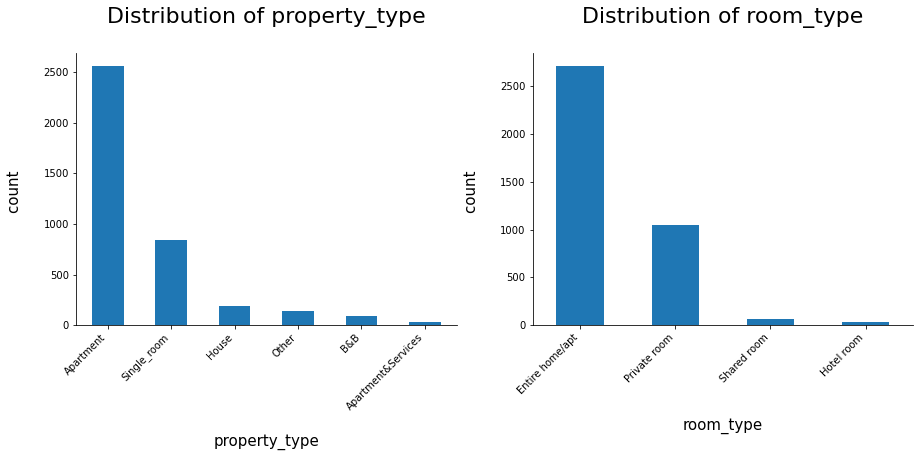

In [15]:
property_and_room()

So we can see that:
- the offer of properties in Bologna consists mainly of several types of apartments about 65% (remember from the cleaning that "apartment" includes: condominium, entire condominium, entire apartment, entire loft and lof).
- followed by the offer of single rooms about 25% and loosely by houses.  
- Aparthotel, B&Bs and other options are the least common offer. 

As for the room type:
- one can easily find entire apartments or homes (meaning that the booking implies that the traveller will be alone in the whole property). This option makes up the greatest part of the offer. 
- then a relatively significant portion of the market is composed of private rooms signaling that privacy is a great added value when booking properties on Airbnb. 
- The least common offer in terms of room_type is the shared room and hotel room - this because this type of hospitality typically uses other platforms such as Booking.

## Most common setup

In [16]:
#WHAT IS THE MOST COMMON SETUP
def draw_histograms(df, variables, n_rows, n_cols):
    """
    function that plots the histogram of the passed variables  
    """
    fig=plt.figure(figsize=(8,12))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title('"'+var_name+'"'+ ' attribute distribution', fontsize=22)
        ax.set_xlim(0,max(df[var_name]))
        ax.grid(False)
    fig.tight_layout()  
    plt.show() 

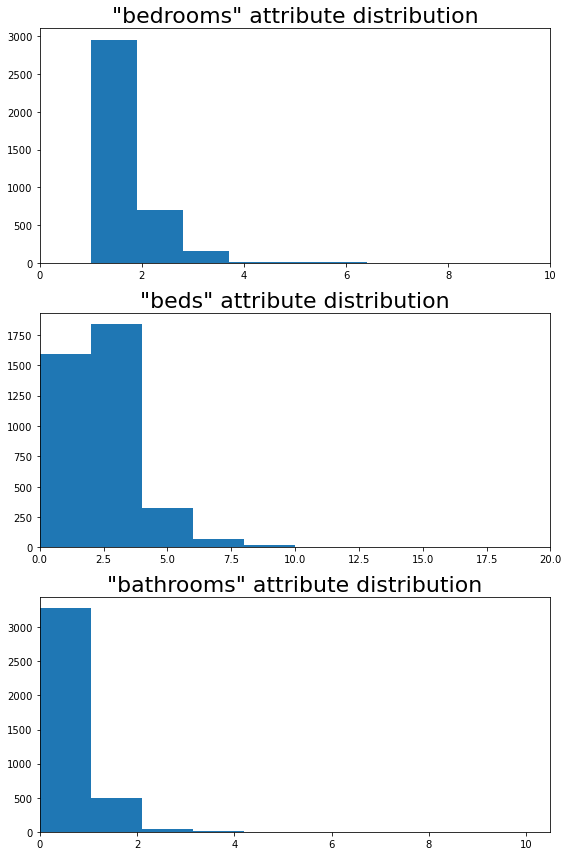

In [17]:
draw_histograms(df,['bedrooms','beds','bathrooms'],3,1)

The most common set-up consists in offering 1 bedroom, with 2 beds and at least 1 bathroom. 

---

## Reviews

So far we have the most common offer and as a potential host my possible strategies are either: 
- a) cost focus -> seeking cost advantage (offer a product similar to that being offered but adjust the price to be more competitive - price and cost are not the same but we only have price so that's what we are using)
- b) product differentiation ->  change your proposal in order to answer special needs of buyers  

to understand which option is preferable the host needs to understand if the customers are currently satisfied with the offer so first we look at the reviews to have a feeling of the customers's satisfaction

In [18]:
# overall listing rating -> this in histplot because it goes up to 100
def plot_overall_rating():
    sns.histplot(df['review_scores_rating'], kde=True, bins=20)
    sns.despine()
    plt.title('Overall listing rating', fontsize=14)

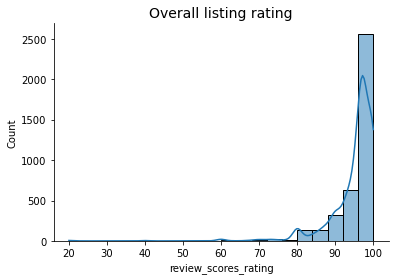

In [19]:
plot_overall_rating()

- Ratings for the listings in Bologna are generally rather high (>91, most frequent rating is 97 followed by 100 then the first most frequent 10 values are >90). 
- When not in this excellent position, listings tend to be around 80 so good but not excellent. 
- Very few listings have less than 60 but if less than 60 then goes directly down to 20. 
- overall customers seem to be satisfied with the offer meaning that when booking a property in Bologna they actually want mainly a room in an apartment with 2 beds and one bathroom so I would advise a potential host not to change this formula

Yet, this overall evaluation is broken down into 6 dimensions so as a potential host I might be interested in understanding whether there is a particular aspect that current hosts are not answering/partially answering (as I could start by tackling that aspect first in order to attract costumers )

In [20]:
#this is the overall rating, let's see how is broken down for each aspect of the evaluation
#(loc)

def rating_breakdown():
    dim_of_eval = dim_of_eval = list(set(df.columns[df.columns.str.startswith("review_scores") == True]) -set(['review_scores_rating']))
    fig, ax = plt.subplots()
    #plt.title('Analysis of the rating - broken down per dimension \n', fontsize=22 )
    for col in dim_of_eval:
        sns.histplot(df[col], bins=20)
        sns.despine()
        plt.title("Distribution of the reviews for "+ col.rsplit('_', 1)[-1].upper() +'\n')
        plt.show()

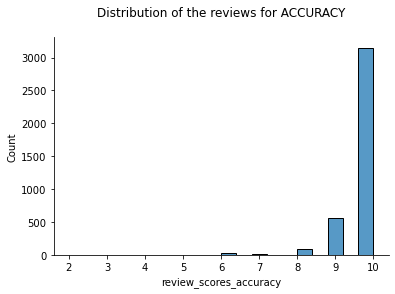

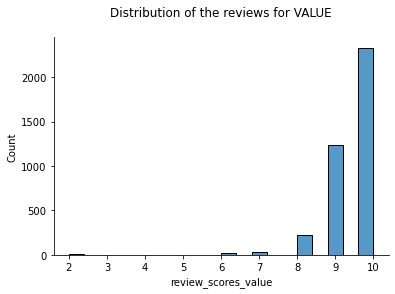

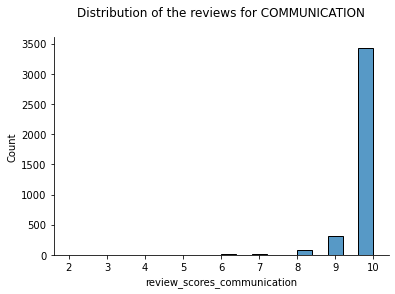

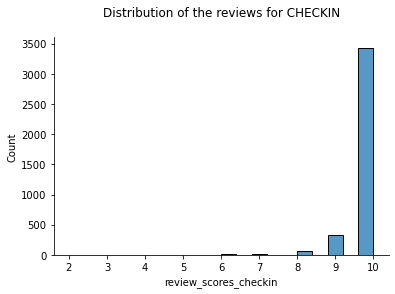

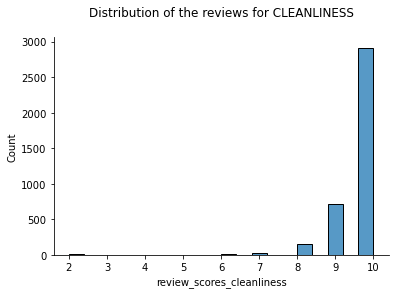

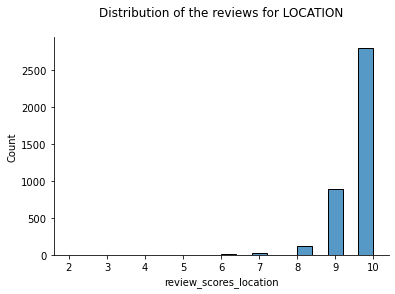

In [21]:
rating_breakdown()

- Ratings tend to be high in all dimensions of evaluation.
- There is not one striking dimension on which a new host could focus to better answer customers' needs- 
- however, if a suggestion is to be given, since accuracy and cleanliness are those with relatively lower reviews, as a potential host I would make sure to tackle these aspects by offering a clean environment and ensuring that customers have realistic expectations of the property. 

We are grounding the choice for the strategy on the reviews but are these actually reflecting the current situation? We could be talking about years old reviews which would be less reliable. So we check how many of the listings have had their last review in the last 6 months obtaining the following result.

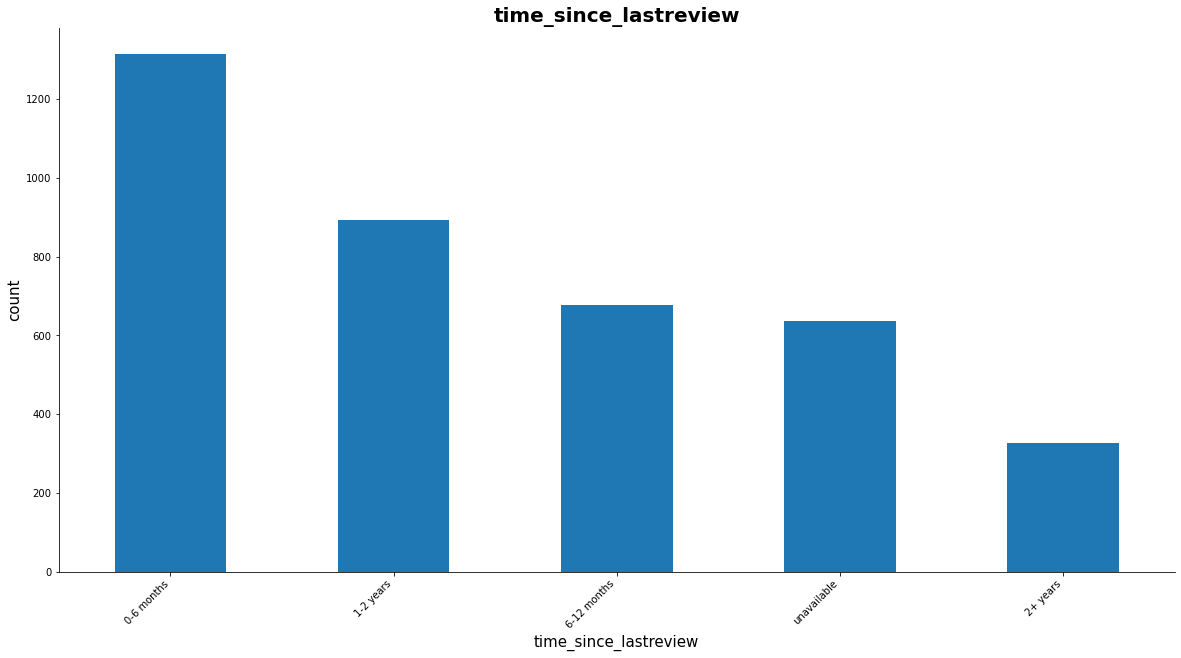

In [22]:
 category_count_plot(df, 'time_since_lastreview')

Most of the listings have had their last review in the last 6 months so I know I can relatively trust the picture given by the reviews and should assume customers are relatively satisfied with the offer. Also, this gives us a feeling of the current engagement with the platform.

Note: clearly, analyzing the reviews only gives us the opinion of the current customers, the demand of potential customers is left untapped - meaning I could choose to differentiate my offer and still be successfull because I am attracting customers that have never booked with Airbnb before but, still, we assume we can relatively generalize to entire demand.

> **Bottom line for the host:** changing the current setup (which is mainly for one or two people) is not advisable for a potential host, there is no evidence to adopt a differentiation strategy as for property and setup. Focusing on the cost seems a more advisable plan of action.

---

## Price analysis 
So the current setup seems to work with the customers and as a potential host I should focus on the price. The cost seems to be a better action lever (wrt differentiate the offer of setup) so we look at the current offer in terms of prices.

### overall distribution

In [23]:
# What is the overall distribution of prices?
print(f"Nightly advertised prices range from €{min(df.price)} to €{max(df.price)}.")

Nightly advertised prices range from €9 to €2000.


In [24]:
# Distribution of prices from 0 to 500€ - (would go up to 3000€ for November data) 
# FOCUS ON THE LEFT BECAUSE THAT'S WHERE MOST OF THE PROPERTIES ARE

def plot_price_distribution():
    """
    function that plots the distribution of the price only up to 500€
    """
    plt.figure(figsize=(20,4))
    df.price.hist(bins=100, range=(0,500)) #used max(df['price']) so 3000 but most listings are way below
    plt.margins(x=0)
    plt.title("Airbnb advertised nightly prices in Bologna up to 500€", fontsize=16)
    plt.xlabel("Price (€)")
    plt.ylabel("Number of listings")
    plt.axvline(df['price'].median(), color='orange', linestyle='--') #most listings have a price below 
    min_ylim, max_ylim = plt.ylim()
    plt.text(df['price'].median()*1.1, max_ylim*0.9, 'Median price: {:.2f}'.format(df['price'].median()))
    plt.show()
    #heavy tailed prices (to keep in mind when predicting)

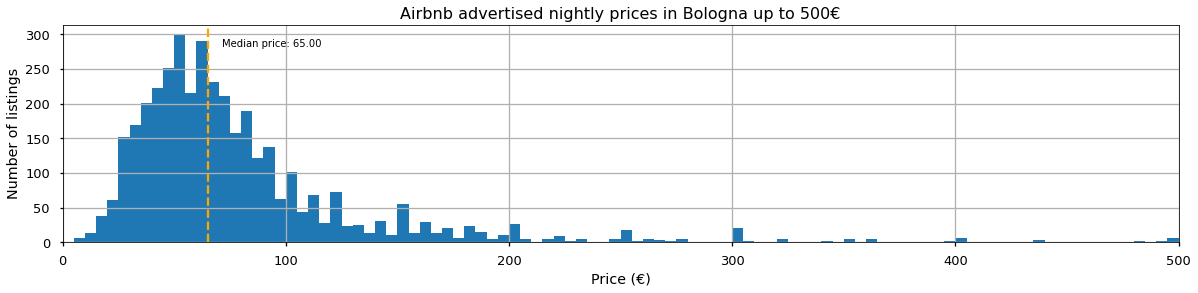

In [25]:
plot_price_distribution()

- the nightly price for properties on airbnb in Bologna ranges from just 9€ to 3000€. 
- most properties ask for a nightly price lower than 65€ 
- the price feature is tail heavy (ie. it extends to much farther to the right of the median) - in this analysis all listings are kept but in visualization and models the price is log transformed (to have a more normal distribution) and/or a cutoff point is chosen for better understanding the visualisations (as in this case the price distribution is plot only up to 500€).

### Trend in time
This is the current picture but how have prices changed over time? We take as reference the year of the first review and plot the boxplot of the prices per year


In [26]:
def plot_price_trend():
    plt.figure(figsize=(16,6))
                                                #log transformation of the price to make them comparable 
    sns.boxplot(x = df['first_review'].dt.year, y = np.log(df['price'])) 
    plt.xlabel('\n Year (of the first review for the listing) ', fontsize=15)
    plt.ylabel('Price per night (log-transformed)', fontsize=15)
    plt.title('Behavior of the price of listings in Bologna for each year \n', fontsize=22)
    plt.show()

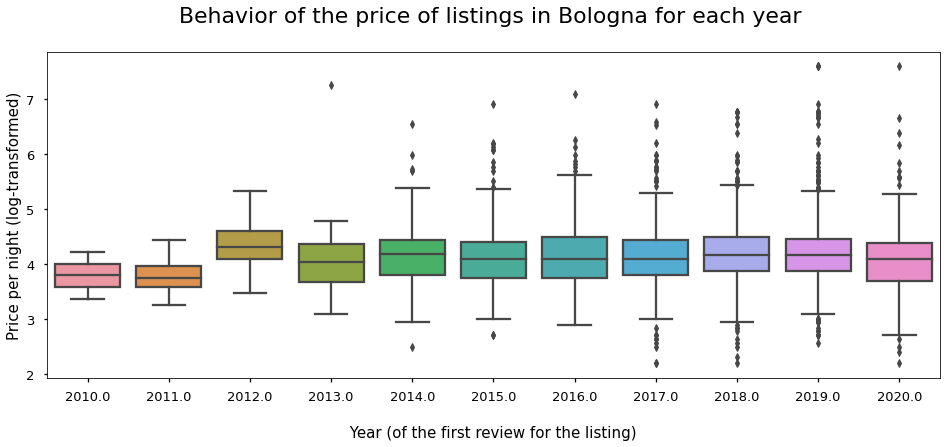

In [27]:
plot_price_trend()

To a potential host I would say that there is no striking trend to be spotted in the price variation throughout the years but if we keep into account small variations then: 
- in the last ten years there has been an increase in price variability and a slight increase in mean price (in 2020 price is higher than 2010) with a peak registered in 2012
- however in the last year one can notice that the mean price has decreased but this is clearly something one should expect given the consequences of the pandemic on tourism

### Relationship price and reviews
Here the price gets analyzed by plotting the scatterplot of price and reviews to understand their interplay

In [28]:
# REVIEWS AND PRICE 
#scatterplot price e review

def scatterplot_total():
    """
    function to assess the relationship between price and reviews by plotting the scatterplot 
    (all prices are plot)
    """
    plt.scatter(df['price'],df['review_scores_rating'])
    plt.xlabel('price (€)')
    plt.ylabel('review score')
    plt.title('Scatter plot of review rating vs. price')
    plt.show()

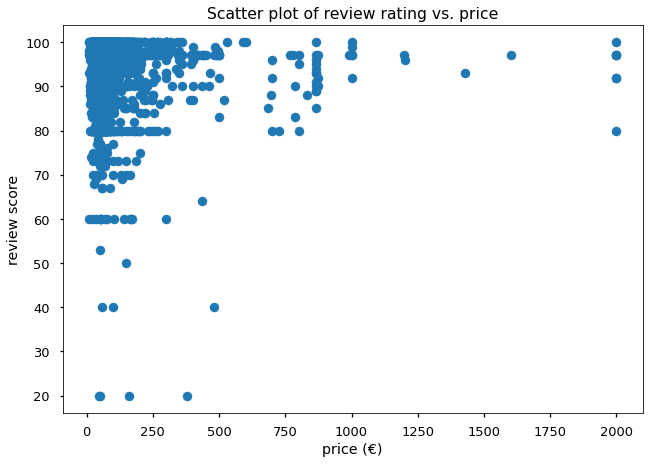

In [29]:
scatterplot_total()

- customers are satisfied with high prices listings (as there are no listings with high nightly prices that have low reviews).  
- but this does not mean that lower prices have lower reviews. In fact, despite some extremely cheap listings that made customers complain (20/40), most high reviews concentrate on the lower side of the prices. 
- overall, customers tend to give very high ratings to properties (>=80) regardless the price (to a certain extent).

In [30]:
# FOCUS ON SMALLER PRICES
def focus_scatterplot():
    """
    function to assess the relationship between price and reviews
    focusing on most common prices (up to 200€)
    """
    data = df[df['price'] < 200]
    plt.scatter(data['price'],data['review_scores_rating'])
    plt.xlabel('price (€)')
    plt.ylabel('review score')
    plt.title('Scatter plot of review rating vs. price - focus on smaller prices')
    plt.show()

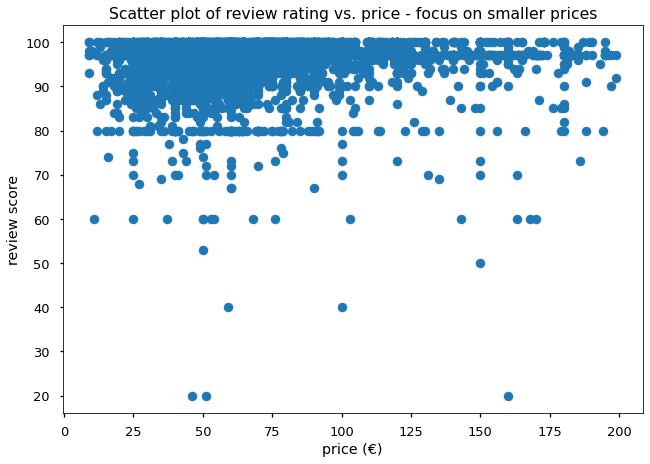

In [31]:
focus_scatterplot()

If we assume the reviews represent the demand (we don't have data about the actual bookings - ie. the current demand - so we use reviews as a proxy) one could conclude that there is low elasticity in the demand because, especially up to about 125€, reviews are consistently high.

Note: clearly there are some limits: a) reviews only measure "current" demand b) properties being offered on the platform are generally cheaper. 

> **Bottom line for a potential host:** customers are relatively indifferent to reltively higher prices up to about 100€

### Median price charged per number of people hosted 

In [32]:
def count_and_medianprice_perpeopleaccomodated():
    """
    to display the popularity of listings per n° of people accomodated by the property
    together with the associated median price 
    """
    #Number of listings (=offer) per people accomodated compared to price 
    df.loc[:,'dummy'] = 'dummy' #this is needed just to have the bars not overlapping 
    #matplotlib does this automatically but seaborn is better looking 

    #Create combo chart
    fig, ax1 = plt.subplots(figsize=(10,6))

    color = '#000000' #black
    #bar plot creation
    ax1.set_title('Offer of listings and median price for number of people accommodated \n', fontsize=20)
    ax1.set_xlabel('accommodates', fontsize=16)
    ax1.set_ylabel('count', fontsize=18, color= color)
    ax1 = sns.countplot(data=df,x='accommodates', fill= False) 
    ax1.tick_params(axis='y')

    #specify we want to share the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:green'
    #line plot creation
    ax2 = sns.barplot(x='accommodates',y='price',data=df,hue='dummy', color = 'tab:green', ci=None, hue_order=['other','dummy'])
    ax2.set_ylabel('\n Median price', fontsize=18, color=color)
    ax2.tick_params(axis='y', color=color)

    ax2.legend_.remove()

    #show plot
    plt.show()

    df.drop(['dummy'],axis=1, inplace=True)

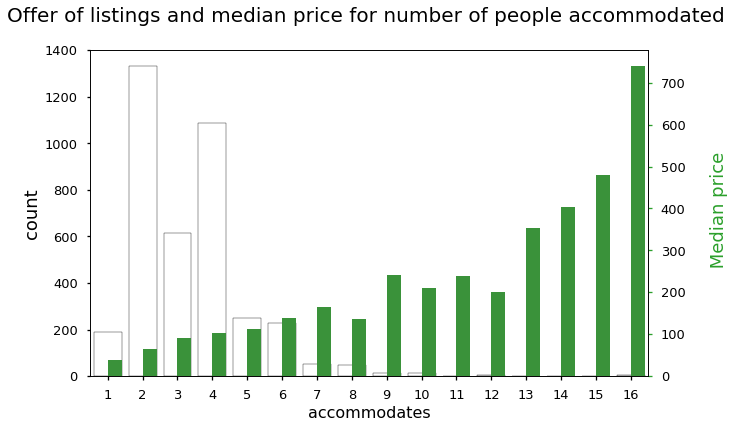

In [33]:
count_and_medianprice_perpeopleaccomodated()

Reasonably, the price is higher for properties that accomodate a greater number of people but the return stops to grow linearly after about 7 people accomodated. This means that the relationship between the median price charged and the number of people the property can accomodate is linear only up to about 7 people, then the behavior is less predictable. 

In fact, for one additional person accomodated there is no increase from 7 to 8 people but then one additional person from 8 to 9 significantly increase the price but then again from 9 to 10 the price decrease. 

Since the returns do not justify having properties that accomodate a great number of people it's advisable for a potential host to remain below 4 people accomodated even though that's where most of the market is offering (and so the competition is fiercer). 

> **Bottom line for the host:** there is not a linear relationship between people hosted and median price and most offer is focused on hosting less people - you charge less as nightly price but it represents a more steady income.

---

## Which area of Bologna has the most properties?
Since the competiton will be fiercer as a host I might be interested in focusing on areas that have less properties. So here the density of properties being offered is analyzed (using Folium) as follows:
* first all listings available are plotted to have a feeling of the area
* then the heatmap because it helps us better understanding where the offer is focused
* the heatmap gives us an overall view but we want the actual name of the neighbourhood (because those will be used to filter)
* so then we plot a cloropleth map first for the count of listings per neighbourhood then for the median price to assess which areas are the most expensive

### all listings

All the listings currently available on the platform are displayed giving us an idea of how these listings spread around Bologna.

In [34]:
# here I create a map with all listings in Bologna present on Airbnb 
#using latitude and longitude values of the df
def plot_all_listings():
    map_Bolo = folium.Map(location=[latitude, longitude], zoom_start=12)  

    # add markers to map
    for lat, lng, neighbourhood, room_type, rating in zip(df['latitude'], 
                                                          df['longitude'], 
                                                          df['neighbourhood'], 
                                                          df['room_type'], 
                                                          df['review_scores_rating']):
        label = '{}, {}, rating: {}'.format(neighbourhood, room_type, rating)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',  #wanted to use coral which is the color of the logo in airbnb but then confusing 
            fill_opacity=0.7,
            parse_html=False).add_to(map_Bolo)
    return map_Bolo

In [35]:
plot_all_listings()

### Heatmap to better grasp densities

To clearly visualize the density we the heatmap is plot

In [36]:
# Heatmap of number of listings in Bologna 
#to see the density of properties across different areas 

def plot_heatmap():
    m = folium.Map(location=[latitude,longitude],zoom_start=12)

    heat_data = [[row['latitude'],row['longitude']] for index,row in df[['latitude','longitude']].iterrows()]

    hh = HeatMap(heat_data).add_to(m)

    return m

In [37]:
plot_heatmap()

> **Bottom line for the host:** most listings are in the central area but overall are spreaded also in the outskirts, especially close to the airport (north east)

### Which area has the most properties? Which area is the most expensive?
The heatmap allows us to have a birdeye view of the situation but I am more interested in the division of the offer in the various neighbourhood because these are what the platform uses to discriminate the listings. 
So first I provide context for the neighbourhood so that the user can better interpret the maps 

In [38]:
neigh_map = gpd.read_file('neighbourhood.geojson')

In [61]:
%%html
<style>
table {float:left}
</style>

To give some context, the city of Bologna is broken down into 6 neighbourhoods:  
<table>
  <thead>
    <tr>
      <th>Neighbourhood</th>
      <th>Characterization </th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Borgo Panigale - Reno</td>
      <td>close to the airport and greatest</td>
    </tr>
    <tr>
      <td>Navile</td>
      <td>Bolognina and close to Bologna Fiere</td>
    </tr>
    <tr>
      <td>Porto Saragozza</td>
      <td>on the way from the airport to the historical centre</td>
    </tr>
    <tr>
      <td>San Donato - San Vitale</td>
      <td>residential area (POI:FICO Eataly)</td>
    </tr>
    <tr>
      <td>Santo Stefano</td>
      <td>historical centre and very popolous area </td>
    </tr>
    <tr>
      <td>Savena</td>
      <td>Sant'Orsola hospital and Bologna hills</td>
    </tr>
  </tbody>
</table>

In [62]:
def plot_geojson(): 
    """
    function that read the geojson from the geojson file (instead of the URL)
    """
    #print(f"The geometry is of type {neigh_map.geometry.type.unique()}") #the geometry type for each neighbourhood 
    #print(f"The SRID (Spatial Reference ID) is EPSG: {neigh_map.crs.to_epsg()}") #the project coordinate system 
                                                                      #https://spatialreference.org/ref/epsg/wgs-84/
    #print(f"The coordinate referene system of this geopddf is {neigh_map.crs}")

    #print(f"Type of geometry column {type(neigh_map['geometry'][0])}") #it's a geoseries = shapely geometry with other properties
                                                            #cannot be processed as it is by SQLite but requires to be converted into text

    bbox = dict(boxstyle='round', facecolor='white', alpha=1.0)
    ax = neigh_map.plot(figsize=(10, 10), column='neighbourhood', alpha=1.0, edgecolor='k', cmap='Pastel1')
    for i, row in neigh_map.iterrows():
        centroid = row.geometry.centroid.bounds
        ax.text(x=centroid[0], y=centroid[1], s=row.neighbourhood, horizontalalignment='center', fontsize=16, bbox=bbox)
    ax.set_axis_off()
    ax.set_title('Neighbourhoods in Bologna', fontsize=20);

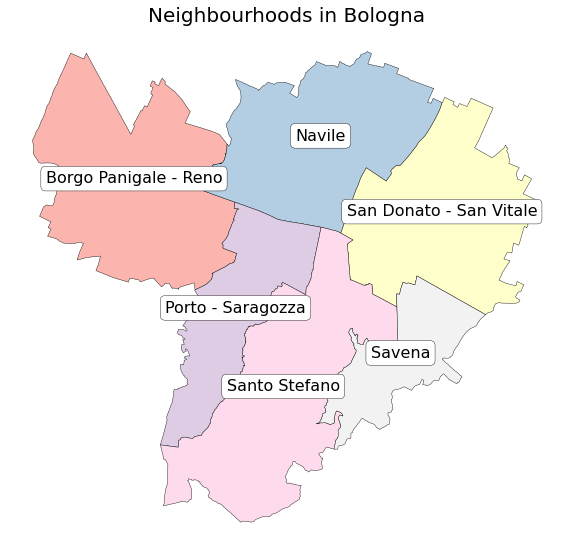

In [63]:
plot_geojson()

SOURCE: [if you want to know more about neighbourhoods](https://www.bolognatoday.it/cronaca/Quartieri-bologna-abitanti-cosa-vedere.html)

In [64]:
#DEFINITION OF THE DATAFRAME USED FOR THE TWO FOLLOWING MAPS

# we need to extract the count of listings from the df 
neigh = pd.DataFrame(df.groupby('neighbourhood').size())                    #how many listings per neighbourhood
neigh.rename(columns={0: 'number_of_listings'}, inplace=True)

#and add the median price per neighbourhood
neigh['median_price'] = df.groupby('neighbourhood').price.median().values   #median price per neighbourhood

# eventually join this df with that with the geometries (map_df)
neigh_map_df = neigh_map.set_index('neighbourhood').join(neigh)  #set the index to join it properly

neigh_map_df['neighbourhood'] = neigh_map_df.index #need to have it as a column for these more interactive viz

Then with Folium library I plot the map with the count of listings per neighbourhood and the median price (the variable of interest gets displayed with the tooltip).

In [91]:
def which_most_common():
    # Create basemap
    fig5 = Figure(width = 900, height = 800)
    m5 = folium.Map(location = [latitude,longitude],zoom_start = 12) #forse con tiles = 'cartodbpositron' meglio (prova e dimmi) 

    folium.GeoJson(
        neigh_map_df,
        style_function=lambda feature: {
            #'fillColor': 'white',
            'color': 'black',
            'weight': 0.5
        }
        ).add_to(m5)

    fig5.add_child(m5)

    # Generate choropleth map 
    folium.Choropleth(
        geo_data = neigh_map_df.to_json(),
        data = neigh_map_df,
        columns=['neighbourhood', 'number_of_listings'],
        key_on = 'feature.properties.neighbourhood',
        fill_color = 'YlGnBu', 
        legend_name = "Number of listings on Airbnb").add_to(m5)

    # Add tooltips
    folium.features.GeoJson(data = neigh_map_df,
                            name = 'Labels',
                            style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                            tooltip = folium.features.GeoJsonTooltip(
                                    fields= ["neighbourhood", "number_of_listings"],
                                    aliases = ["neighbourhood", "count"],
                                    labels=True,
                                    sticky=False
                                                                                )
                            ).add_to(m5)
    # Add title
    title_html = '''
                <h3 align="center" style="font-size:20px"><b>Count of properties by neighbourhood in Bologna</b></h3>
                 '''
    m5.get_root().html.add_child(folium.Element(title_html))

    return m5

    #with the tooltip if you put the cursor on the map you'll see the name of each neighbourhood and the corresponding value

In [92]:
which_most_common()

In [140]:
# Top 3 neighbourhoods according to the feature provided as argument
def top3(feature):
    """
    function that returns the tops 3 neighbourhoods according to the passed feature 
    """
    neigh_map = neigh_map_df.drop(['geometry','neighbourhood'],axis=1)
    res = neigh_map.sort_values(by=feature,ascending=False).head(3)
    return  res.loc[:, [feature]]

In [141]:
top3('number_of_listings')

number_of_listings
neighbourhood                              
Santo Stefano                          1391
Porto - Saragozza                      1268
San Donato - San Vitale                 494

- the area that has the most properties advertised in Airbnb is Santo Stefano followed by Porto Saragozza
- less popular areas are Naville, San Donato/San Vitale
- least popular Borgo Panigale/Reno e Savena 

In [93]:
def most_expensive():
    # Create basemap
    fig3 = Figure(width = 900, height = 800)
    m3 = folium.Map(location = [latitude,longitude], zoom_start = 12) #tiles = 'cartodbpositron'

    folium.GeoJson(
        neigh_map_df,
        style_function=lambda feature: {
            #'fillColor': 'white',
            'color': 'black',
            'weight': 0.5
        }
        ).add_to(m3)

    fig3.add_child(m3)

    # Generate choropleth map 
    folium.Choropleth(
        geo_data = neigh_map_df.to_json(),
        data = neigh_map_df,
        columns=['neighbourhood', 'median_price'],
        key_on = 'feature.properties.neighbourhood',
        fill_color = 'YlOrRd', 
        legend_name = "Median nightly price").add_to(m3)

    # Add tooltips
    folium.features.GeoJson(data = neigh_map_df,
                            name = 'Labels',
                            style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                            tooltip = folium.features.GeoJsonTooltip(
                                    fields= ["neighbourhood", "median_price"],
                                    aliases = ["neighbourhood", "nightly price (€)"],
                                    labels=True,
                                    sticky=False
                                                                                )
                            ).add_to(m3)
    # Add title
    title_html = '''
                <h3 align="center" style="font-size:20px"><b>Median nightly price of listings in Bologna by neighbourhood</b></h3>
                 '''
    m3.get_root().html.add_child(folium.Element(title_html))

    return m3

In [94]:
most_expensive()

In [95]:
#boxplot of the (log transformed) prices per neighbourhood
def variety_per_neighbourhood():
    plt.figure(figsize=(16,6))
    sns.boxplot(x = df['neighbourhood'], y= np.log(df['price']))  
    plt.xlabel('\n neighbourhood ', fontsize=15)
    plt.ylabel('Price per night (log-transformed)', fontsize=15)
    plt.title('Boxplot of the nightly price in Bologna per neighbourhood \n', fontsize=22)
    plt.show()

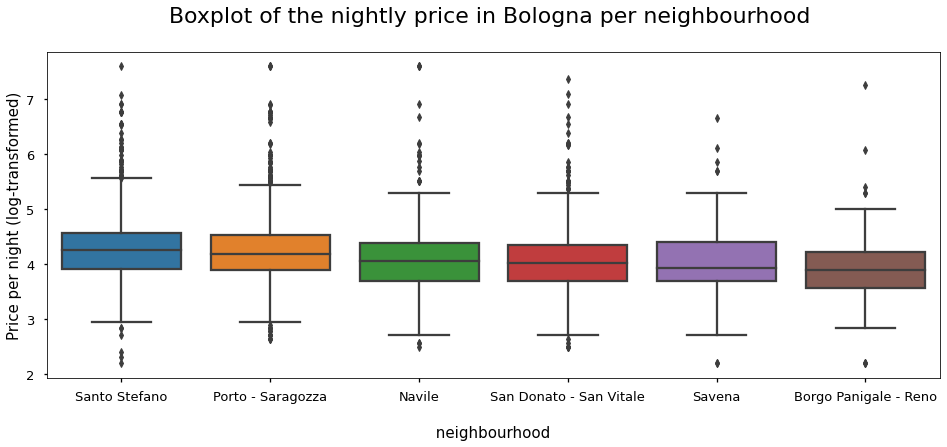

In [96]:
variety_per_neighbourhood()

In [142]:
# Top 3 neighbourhoods where the price is the highest
top3('median_price')

median_price
neighbourhood                  
Santo Stefano                70
Porto - Saragozza            65
Navile                       58

- these above are the top 3 neighbourhood with the associated median price, overall the prices are relatively similar
- Santo Stefano is the historical center so despite the great offer of properties, it has the highest prices
- followed by Porto-Saragozza probably due to the fact that it's in between the airport and the city centre
- then Navile probably because it's just outside the historical centre, to the north of the city.   

<a class="anchor" id="Clustering"></a>

# Clustering 
Using the *neighbourhood* as segmentation tool of the offer is useful but, especially in Santo Stefano (neighbourhood with most properties), listings in one single neighbourhood are still too many to be processed independently. To analize the offer in the same neighbourhood I might be interested in discriminating the listings *according to their similarity*. This is done here feeding the kmeans clustering algorithm with the scores of the principal components. 

In [65]:
#EXPLANATION OF WHAT I'VE DONE HERE AND WHY 

#To do the clustering of the listings the following steps are undertaken:  
# 1. retrieve the dataset
# 2. create dummy variables for categorical variables (and remove first and last review that I use only in the analysis section) 
# 3. apply a dimensionality reduction algorithm (PCA chosen) 

#(we need to use PCA for 2 reasons: 

#(a) [more critical] the dataframe originally contains both datatype, even with categorical variables encoded the 
#                    df could not be fed to a clustering algorithm like KMeans because it uses Euclidean distance 
#                    as pairwise distance (which does not make sense for categorical variables) so first PCA then 
#                    feed scores to clustering.   
#(b) [less critical as here only about 100 features] there are may features so we use PCA to combine the original 
#                                                    attributes in leaner versions of them so that we can focus on 
#                                                    the most important ones (in the first components we are 
#                                                    combining the most important features)
#)

# 4. merge the PCA scores with the dataset (after retrieving the neighbourhood not encoded and creating a new feature called budget that divide the listings according to low,medium, high price)
# 5. apply the clustering algorithm (KMeans) using PCA scores
# 6. output the results directly on the map

In [98]:
#1. APPLY PCA (get PCA scores)

def get_PCAscores():
    #retrieve clean encoded 
    conn = sqlite3.connect(DB_PATH)
    clean_encoded = pd.read_sql("SELECT * FROM df_clean_encoded", conn)
    conn.close()

    #first we need to scale (otherwise it does not make sense to compare the variance associated to each feature )
    X = clean_encoded.drop(['id'], axis=1) #all attributes minus the id
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

    #then need to choose the n° of components(n° of eigenvalues of the eigenvalues matrix generated by SVD)

    #visually we can plot the cumulative explained variance and select the x where the explained variance is 95
    pca = PCA().fit(X)
    #a volte mi è uscito SVD did not converge ma in realtà non era legato ai dati bensì alla memoria 
    #perchè continuavo a lavorare in locale
    #plt.plot(np.cumsum(pca.explained_variance_ratio_))
    #plt.xlabel('number of components')
    #plt.ylabel('cumulative explained variance')

    #I ask for as many components as needed to explain at least 95% of the variance 
    cum_explained_var = []
    for i in range(0, len(pca.explained_variance_ratio_)):
        if i == 0:
            cum_explained_var.append(pca.explained_variance_ratio_[i])
        else:
            cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                     cum_explained_var[i-1])

    n_comp = np.where(np.asarray(cum_explained_var)> 0.95)[0][0]   #cum_explained_var[-1] to get the precise value

    #so PCA with the chosen n° of comp
    pca = PCA(n_components = n_comp)
    model = pca.fit(X)

    #to visualize how much variance is explained by each component
    #features = range(pca.n_components_)
    #plt.figure(figsize=(18,10))
    #plt.bar(features, pca.explained_variance_)
    #plt.xticks(features)
    #plt.ylabel('variance')
    #plt.xlabel('PCA feature')
    #plt.show()

    pca_features = pca.transform(X)
    pca_df = pd.DataFrame(pca_features) 
    #here we have all the scores of the PCA, these will be joined to the (subset of the) original df for clustering

    conn = sqlite3.connect(DB_PATH)
    pca_df.to_sql(name='pca_scores', con=conn, if_exists="replace", index=False) 
    conn.close()

In [99]:
get_PCAscores()

In [100]:
 #2. HERE I CREATE THE BASE DATAFRAME (essentially one with core feature but without the labels )
def create_base_df_withoutlabels():
    
    #2.1 I want the result to be divided per neighbourhood because that's what you canuse to filter on the platform
    #I retrieve the non encoded df 
    conn = sqlite3.connect(DB_PATH)
    clean_notencoded = pd.read_sql("SELECT * FROM df_clean_notencoded", conn)
    conn.close()
    
    #2.2 select a subset of the columns I am interested in (quelle su cui poi si può filtrare la mappa)
    #così da lavorare su un dataset anche più piccolo
    cols = ['neighbourhood','id', 'price', 'minimum_nights', 'bedrooms', 'bathrooms']
    sub = df[cols] #remember df is the not encoded one (defined in the whole environment)
    

    #2.3 I add a feature for the budget (bin del price 4 easier viz)
    #boxplot = notencoded.boxplot(column='price')
    #print(f"Low-medium threshold: {notencoded['price'].quantile(q=0.30)}")
    #print(f"Medium-high threshold: {notencoded['price'].quantile(q=0.80)}")
    low_indexes = sub[sub.price < 50].index
    med_indexes = sub[(sub.price >= 50) &
                             (sub.price < 200)].index
    high_indexes = sub[(sub.price >= 200)].index

    sub.loc[low_indexes, 'budget'] = 'low'
    sub.loc[med_indexes, 'budget'] = 'medium'
    sub.loc[high_indexes, 'budget'] = 'high'

    #2.4 and eventually I merge with the scores from the PCA
    #I retrieve the non encoded df 
    conn = sqlite3.connect(DB_PATH)
    pca_df = pd.read_sql("SELECT * FROM pca_scores", conn)
    conn.close()
    be4clustering = pd.concat([sub, pca_df], axis=1)

    #2.5 and save it 
    conn = sqlite3.connect(DB_PATH)
    be4clustering.to_sql(name='be4clustering', con=conn, if_exists="replace", index=False) 
    #be4clustering is the dataframe with the subset of the the original df
    #and all the scores of the principal components 
    conn.close() 

In [101]:
create_base_df_withoutlabels()

#Settings with copy warning will result from this execution but it's fine

C:\Users\isada\Anaconda3\envs\airbnb_env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\isada\Anaconda3\envs\airbnb_env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [103]:
#3. HERE I APPLY CLUSTERING ALG (essentially I add the labels to that df)
# gather all the PCA components and extract them 

def apply_kmeans():
    #3.1 RETRIEVE DATASET (that without the labels) 
    conn = sqlite3.connect(DB_PATH)
    be4clustering = pd.read_sql("SELECT * FROM be4clustering", conn)
    conn.close()
    
    #3.2 SELECT ONLY THE SCORES FROM THE PCA (which remember that encode the information about all the features)
    pc_col_names = ["pc_" + str(item) for item in list(be4clustering.columns[7:])] #rename them to be easily recognized
    pc_data = be4clustering.iloc[:, 7:] #after the 7th attribute I have all the components 
    #(depending on the dataset I pass, the n° of components can differ so defining it in this way should help with robustness
    #because the columns "cols" will be reasonably the same but the n° of components can change depending on the dataset)
    pc_data.columns = pc_col_names #all the principal components (scores of the listings)

    #3.3 SELECT THE N° OF COMPONENTS
    #here I've used the elbow method to select the n° of clusters to ask for
    #by fitting the algorithm with a number of cluster that goes from 1 to 11 everytime registering the Sum of Squared Errors
    #sse = {}
    #for k in range(1, 11):
    #    kmeans = KMeans(n_clusters=k, random_state=1)
    #    kmeans.fit(pc_data)
    #    sse[k] = kmeans.inertia_ # sum of squared distances to the closest cluster centers

    # then we plot SSE for each n° of cluster aand use the elbow method to select the chosen n° of clusters 
    #plt.title('The Elbow Method')
    #plt.xlabel('$k$', fontsize=14)
    #plt.ylabel('SSE', fontsize=14)
    #sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

    #plt.annotate('Elbow',
    #             xy=(2, sse[2]),
    #             xytext=(0.55, 0.55),
    #             textcoords='figure fraction',
    #             fontsize=16,
    #             arrowprops=dict(facecolor='black', shrink=0.1)
    #            )
    #plt.show()

    #Strictly following the elbow method we should choose K=2 because the elbow is in corresponence of this n° of clusters 
    #(sharp decrease in SSE) but there is not much difference with K=3 and 3 are also the levels of the budget so 
    #we can check if K-means clustering picks out the listings by grouping them as per their budget range.

    #depending on the dataset the preferable n° of clusters could change but I expect to not differ too much
    #also 3 is a reasonable n° of groups for something that needs to be used by a potential host 

    #3.4 APPLY THE ALGORITHM
    
    #BRIEF DISCUSSION ABOUT THE CHOICE OF THE ALGORITHM:
    #kmeans was chosen because simplest and fastes but
    #it has 2 main drawbacks for this application:
    #a) kmeans does not perform too well with non-circular shapes and I expect the resulting clusters in a city to 
    #be non circular 
    #b) kmeans require to encode categorical variables and perform PCA first in order to perform the clustering
    #on the score. This, however, makes the interpretation less intuitive (similarity is in terms of principal components
    #not actual fetures and if I were the potential host I would like to understand on which variables those listings 
    #are similar so that I can compare them with those I would offer)
    #so an alternative solution could be 
    #to perform clustering only on the amenities (leaving them categorical) with kmodes algorithm 
    #though the tradeoff is more expensive computation AND if the features assessed are many then you would still need 
    #PCA in order to reduce dimension
    
    #apply kmeans
    kmeans = KMeans(n_clusters=3, random_state=223)
    kmeans.fit(pc_data)

    #then extract the resulting labels that we add to the dataframe 
    cluster_labels = kmeans.labels_                                  #extract the labels
    pc_data_k3 = pc_data.assign(cluster=cluster_labels)              #add them to the df with the components 
    other_col_names = list(be4clustering.columns[:7])                #retrieve the columns different than the components 
    afterclustering = be4clustering[other_col_names]                 #select them 
    afterclustering = afterclustering.assign(cluster=cluster_labels) #and assign the cluster label to the listing (df without the PCA scores)

    #save it 
    conn = sqlite3.connect(DB_PATH)
    afterclustering.to_sql(name='afterclustering', con=conn, if_exists="replace", index=False) 
    #dataset with the relevaant columns from the original df and the assigned label
    conn.close() 

In [108]:
apply_kmeans()

In [48]:
#4. VISUALIZE RESULTS ON THE MAP

In [109]:
conn = sqlite3.connect(DB_PATH)
after_clustering = pd.read_sql("SELECT * FROM afterclustering", conn)
conn.close()

In [110]:
def plot_results_for_dashboard(area, budget, bedrooms, bathrooms): 
    """
    function for the dashboard that allows you to filter the result for 
    neighbourhood, n° of bathrooms, n° of bedrooms and budget
    
    takes as input the result of the kmeans clustering (the df with the labels), 
    subsets according to the chosen neighbourhood and selects only the listings with low budget, 1 bedroom and 1 bathroom 
    and display the result on the map
    """
    #1. retrieve dataset and subset it for what you're interested in
    conn = sqlite3.connect(DB_PATH)
    kmeanspd = pd.read_sql("SELECT * FROM afterclustering", conn)
    conn.close()
    
    #first thing first subset
    #budget='low'
    #bedrooms=1
    #bathrooms=1
    latitude=44.4937577
    longitude=11.3430308
    kmeanspd = kmeanspd[(kmeanspd['neighbourhood']==area) & (kmeanspd['budget']==budget)&(kmeanspd['bedrooms']==bedrooms)&(kmeanspd['bathrooms']==bathrooms)]
    
    #2. add latitude and longitude 
    conn = sqlite3.connect(DB_PATH)
    num = pd.read_sql("SELECT * FROM numerical_attributes", conn)
    conn.close()
    coord = num[['id','latitude','longitude']]
    kmeansmap = pd.merge(left=kmeanspd, right=coord, left_on='id',right_on='id')
    
    #then add geometry for the neighbourhood and plot them 
    map_df = gpd.read_file('neighbourhood.geojson')
    map_df = map_df[map_df['neighbourhood']==area]
    
    fig55 = Figure(width = 800, height = 800)
    m55 = folium.Map(location = [latitude,longitude], zoom_start = 12) #tiles = 'cartodbpositron'

    folium.GeoJson(
        map_df,
        style_function=lambda feature: {
            #'fillColor': 'white',
            'color': 'black',
            'weight': 0.5
        }
        ).add_to(m55)

    fig55.add_child(m55)
    
    #then add geometries for the listings longitude and latitude turning it into geopandas and plot the points
    kmeansmap_geo = gpd.GeoDataFrame(kmeansmap, geometry=gpd.points_from_xy(kmeansmap.longitude,kmeansmap.latitude))
    kmeansmap_geo.crs = "EPSG:4326"

    #add the listings
    folium.GeoJson(kmeansmap_geo).add_to(m55)
    #fig.add_child(m)

    # eventually build markers and popups
    for row in kmeansmap_geo.iterrows():
        row_values = row[1]
        center_point = row_values['geometry']
        location = [center_point.y, center_point.x]
        if row_values['cluster'] == 0: #cluster 0 -> verde
            marker_color = 'green'
        elif row_values['cluster'] == 1:  #cluster 1 -> blu    non molto color blind friendly ma pazienza 
            marker_color = 'cadetblue'
        else:
            marker_color = 'beige' #cluster 2 -> beige     
        popup = ('ID: ' + str(row_values['id']) +
                     '\n  ' + 'PRICE:' + str(row_values['price'])+
                     '\n  ' + 'budget: ' + str(row_values['budget'])) #chiaaramente in questo caso sono tutti low ma dipenderà da cosa gli da uno
        marker = folium.Marker(location = location, popup = popup, icon=folium.Icon(color=marker_color, icon='home'))
        marker.add_to(m55)

    display(m55)
    
interactive(plot_results_for_dashboard, area = neigh_map['neighbourhood'], budget= list(after_clustering['budget'].unique()), bedrooms = list(df['bedrooms'].unique()), bathrooms = list(np.sort(df['bathrooms'].unique())) )

interactive(children=(Dropdown(description='area', options=('Borgo Panigale - Reno', 'Navile', 'Porto - Sarago…

In [95]:
#HERE THE FUNCTION DEFINED IN THE CODE 
#TO MAKE IT WORK AS A DASHBOARD IT NEED TO BE DEFINED AS ABOVE
#BUT I LEAVE THE ORIGINAL ONE HERE AS IN THIS 
#ONE CAN FILTER ALSO ON THE BUDGET, BEDROOMS & BATHROOMS 
#(not implemented in the dashboard because no time left)



#area_dropdown = widgets.Dropdown(
#    options=[('Santo Stefano', neigh_map['neighbourhood'][4]), 
#             ('Porto - Saragozza', neigh_map['neighbourhood'][2]), 
#             ('Navile', neigh_map['neighbourhood'][1]),
#             ('San Donato - San Vitale', neigh_map['neighbourhood'][3]),
#             ('Savena',neigh_map['neighbourhood'][5]),
#             ('Borgo Panigale - Reno', neigh_map['neighbourhood'][0])],
#    description='Area:',
#)

#display(area_dropdown)


In [96]:

# FUNCTION THAT VISUALIZES RESULTS ON A SELECTED NEIGHBOURHOOD

#neighbourhood = dropdown.value
#def visualize_result(neighbourhood, budget='low', bedrooms=1, bathrooms=1, latitude=44.4937577,longitude=11.3430308): 

#    function that takes as input the result of the kmeans clustering and visualize on a map.
#    mandatory arg: neighbourhood
#    optional: budget (default=low), bedrooms(default=1) and bathrooms(default=1)
#    (latitude and longitude are defined in the global environment but I also define them for future applications)

    #1. retrieve dataset and subset it for what you're interested in
#    conn = sqlite3.connect(DB_PATH)
#    kmeanspd = pd.read_sql("SELECT * FROM afterclustering", conn)
#    conn.close()
    #first subset (hopefully reduces computation)
#    kmeanspd = kmeanspd[(kmeanspd['neighbourhood']==neighbourhood) & (kmeanspd['budget']==budget)&(kmeanspd['bedrooms']==bedrooms)&(kmeanspd['bathrooms']==bathrooms)]
    
    #2. add latitude and longitude 
#    conn = sqlite3.connect(DB_PATH)
#    num = pd.read_sql("SELECT * FROM numerical_attributes", conn)
#    conn.close()
#    coord = num[['id','latitude','longitude']]
#    kmeansmap = pd.merge(left=kmeanspd, right=coord, left_on='id',right_on='id')
    
    #then add geometry for the neighbourhood and plot them 
#    map_df = gpd.read_file('neighbourhood.geojson')
#    map_df = map_df[map_df['neighbourhood']==neighbourhood]
    
#    fig55 = Figure(width = 800, height = 800)
#    m55 = folium.Map(location = [latitude,longitude], zoom_start = 12) #tiles = 'cartodbpositron'

#    folium.GeoJson(
#        map_df,
#        style_function=lambda feature: {
#            #'fillColor': 'white',
#            'color': 'black',
#            'weight': 0.5
#        }
#        ).add_to(m55)

#    fig55.add_child(m55)
    
    #then add geometries for the listings longitude and latitude turning it into geopandas and plot the points
#    kmeansmap_geo = gpd.GeoDataFrame(kmeansmap, geometry=gpd.points_from_xy(kmeansmap.longitude,kmeansmap.latitude))
#    kmeansmap_geo.crs = "EPSG:4326"

    #add the listings
#    folium.GeoJson(kmeansmap_geo).add_to(m55)
    #fig.add_child(m)

    # eventually build markers and popups
#    for row in kmeansmap_geo.iterrows():
#        row_values = row[1]
#        center_point = row_values['geometry']
#        location = [center_point.y, center_point.x]
#        if row_values['cluster'] == 0: #cluster 0 -> verde
#            marker_color = 'green'
#        elif row_values['cluster'] == 1:  #cluster 1 -> blu    non molto color blind friendly ma pazienza 
#           marker_color = 'cadetblue'
#        else:
#            marker_color = 'beige' #cluster 2 -> beige     
#        popup = ('ID: ' + str(row_values['id']) +
#                     '\n  ' + 'PRICE:' + str(row_values['price'])+
#                     '\n  ' + 'budget: ' + str(row_values['budget'])) #chiaaramente in questo caso sono tutti low ma dipenderà da cosa gli da uno
#        marker = folium.Marker(location = location, popup = popup, icon=folium.Icon(color=marker_color, icon='home'))
#        marker.add_to(m55)

#    display(m55)   

In [82]:
#visualize_result(neighbourhood) 
#possible neighbourhoods are ['Santo Stefano', 'Porto - Saragozza', 'Navile','San Donato - San Vitale', 'Savena', 'Borgo Panigale - Reno']

This allows me to have the listings in the same neighbourhood divided into 3 clusters according to their relative similarity (similarity in terms of principal components so similar according to a combination of the original features - I understand this similarity can result as less intutitive than a similarity on the original features but having compined datatypes on the dataset forbids us from clustering directly on the original features). 

As example of a use case of this map:
- as a customer I could look at this map and say that I am looking for a listing in Santo Stefano near Giardini margherita then I can see that on the left I have 3 listings all belonging to the same cluster but using the tooltip I can identify the one with the lowest price
- as a host I could use this map to see how similar my listing is to other listings in my area and compare prices (price setting is a crucial issue for hosts on Airbnb as there is no guide so usually to do this you look at the prices that is set by similar properties in your area - this allows you to recognize which are the properties similar to you and see their price)

In [97]:
# THIS IS THE FUNCTION TO PLOT THE RESULTS OF THE CLUSTERING ON THE WHOLE CITY 
# I'VE OPTED FOR DISPLAYING ONLY THE SINGLE NEIGHBOURHOOD AS I BELIEVE A HOST WOULD BE INTERESTED 
# JUST IN THE NEIGHBOURHOOD WHERE HIS PROPERTY LIES AND ALSO FOR VISUALIZATION PURPOSES 
# SINCE EVEN IF THE DF HAS BEEN FILTERED THE MARKERS ARE STILL MANY WHICH AFFECTS INTERPRETABILITY


#fig7 = Figure(width = 800, height = 800)
#m7 = folium.Map(location = [latitude,longitude],zoom_start = 12) #forse con tiles = 'cartodbpositron' meglio (prova e dimmi) 

#folium.GeoJson(
#    map_df,
#    style_function=lambda feature: {
#        #'fillColor': 'white',
#        'color': 'black',
#        'weight': 0.5
#    }
#    ).add_to(m7)

#fig7.add_child(m7)

# Build markers and popups
#for row in kmeansmap_geo.iterrows():
#    row_values = row[1]
#    center_point = row_values['geometry']
#    location = [center_point.y, center_point.x]
#    if row_values['cluster'] == 0: #cluster 0 -> verde
#        marker_color = 'green'
#    elif row_values['cluster'] == 1:  #cluster 1 -> blu    non molto color blind friendly ma pazienza 
#        marker_color = 'cadetblue'
#    else:
#        marker_color = 'beige' #cluster 2 -> beige     
#    popup = ('ID: ' + str(row_values['id']) +
#             '\n  ' + 'PRICE:' + str(row_values['price'])+
#             '\n  ' + 'budget: ' + str(row_values['budget'])) #chiaaramente in questo caso sono tutti low ma dipenderà da cosa gli da uno
#    marker = folium.Marker(location = location, popup = popup, icon=folium.Icon(color=marker_color, icon='home'))
#    marker.add_to(m7)


# Add title
#title_html = '''
#           <h3 align="center" style="font-size:20px"><b>Clustering of the listings in Bologna</b></h3>
#             '''
#m7.get_root().html.add_child(folium.Element(title_html))

#m7


Current work stream is focused on clustering the listings incorporating data from the Foursquare API so to add similarity in terms of venues nearby the property but this is still under making (pipeline exceeds daily quota of the API)

<a class="anchor" id="Insights"></a>

# Insights (price prediction, which amenities, superhost & verified)

In [98]:
#ALL THE MARKDOWN THAT WAS DELINEATING THE PROCESS I TURNED IT INTO COMMENT 
#IN ORDER NOT TO HAVE IT IN THE APPLICATION
#BUT STILL INCLUDE IT IN THE CODE TO PROVIDE EXPLANATIONS


#To formulate suggestion on price setting and amenities/features adopted, here a random forest is trained to predict 
#the price and assess feature importance. 

#Several models have been trained (linear - with appropriate transformation of the data to satisfy assumptions - and non linear) but random forest appeared as the most performant one. In the interest of time neural networks have not been applied but could represent interestings follow-up on this project. 

#To do this the following steps have been followed: 
#1. retrieval of the data 
#2. split into training and testing subset 
#3. create base model 
#4. tune hyperparameters with GridSearch
#5. formulate predictions 
#6. assess feature importance of the model to understand which variables most affect the price
#7. to make the choice of amenities more intuitive, together with the assessment of feature importance, a comparison of the median price of listing having vs not having a specific amenity has been carried out. 


#Note: another alternative solution for formulating suggestions coud have been to look sort the listings according to their review (single review_rating or weighted composition of the different dimensions of evaluation), take only the 50 best listings and check which amenities they offer. However shortcomings of using the reviews are that:
#- they are generally really high so it does not allow us to actually discriminate between listings 
#- we have reviews only for listings that have been booked at least once disregarding properties new to the market (which is not advisable for an application that is targeted also to new hosts)

## PRICE PREDICTION - random forest regressor
A common problem for new hosts is to set the price of the property being listed as Airbnb only provides some general guidance. Hence, usually what people do is to look for properties similar to theirs and fix the price accordingly. 

The clustering tool in the previous section is one way forward the automatization of this process. However, as explained above, the *similarity* is not so intuitive because of the PCA so there should be a solution that provides the host directly with the price to be set. 

To do so, here a random forest regressor is trained to predict the price. Due to time constraints, only the Proof of Concept is provided here but the model can be accessed through the MinIO API

In [111]:
#DATA ACQUISITION

#prendo il df così come esce dalla pulizia, encoded perchè mi serve per la regressione 
#(DA CONFRONTARCI ANCHE QUI perchè volendo potremmo prendere il df con gli scores della PCA e usare quelli
#ma in realtà RF non ha troppi problemi con la collinearità e l'altà dimensionalità dei dati quindi 
#potremmo anche tenere direttamente quello non encoded così forse nche più intuitivo)


#retrieve clean encoded 
conn = sqlite3.connect(DB_PATH)
clean_encoded = pd.read_sql("SELECT * FROM df_clean_encoded", conn)
conn.close()

clean_encoded.drop(['id','latitude','longitude'],axis=1, inplace=True) #these are not needed

In [137]:
#def multi_collinearity_heatmap(df, figsize=(11,9)):
    
#    """
#    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
#    """
#    
#    # Set the style of the visualization
#    sns.set(style="white")
#
#    # Create a covariance matrix
#    corr = df.corr()
#
#    # Generate a mask the size of our covariance matrix
#    mask = np.zeros_like(corr, dtype=np.bool)
#    mask[np.triu_indices_from(mask)] = True
#
#    # Set up the matplotlib figure
#    f, ax = plt.subplots(figsize=figsize)
#
#    # Generate a custom diverging colormap
#   cmap = sns.diverging_palette(220, 10, as_cmap=True)

#    # Draw the heatmap with the mask and correct aspect ratio
#    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [138]:
#multi_collinearity_heatmap(clean_encoded,figsize=(30,30))

Area of high correlation are among reviews (unsurprinsingly, if one is satisfied with the property all aspects appeaar to be fine), domestic appliances vs eating basics and different types of property and room type. 

As expected there is high correlation between:
- beds and accomodates (clearly the more people the property accomodates, the more bedrooms, beds etc) -> I'll remove accomodates to reduce collinearity
- n° of reviews and reviews per month (sum of the other)-> I'll keep n° of reviews because this is the number that a potential customer will see on the platform 
- eating_basics e gli actual basics (quindi stove, microwave, etc) -> tolgo eating_basics perchè ho unaa feature per ogni basic item più o meno

Other that are correlated but are left: 
- private room e single room same meaning of the level but for two different features so I'll leave both
- review_score_communication e review_score_checkin perchè probabilmente parlandosi di più il checkin è stato più chiaro (se il checkin non è stato facile da fare imputano la causa alla poca comunicazione)

In [123]:
def forest_reg(df):
    print("Selecting the dataframe...")
    #to_drop = ['accommodates','reviews_per_month','eating_basics']
    #df.drop(to_drop, axis=1, inplace=True)
    # no need to scale the features because RF is not affected by monotonic transformations of the data
    
    print("...splitting it in train and test...")
    #1. SPLIT THE DATASET
    X = df.drop('price', axis=1)            #predictors 
    Y = np.log(clean_encoded['price'])      #target variable (log transformed because left skewed)

    # Create train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=223)
    #https://scikit-learn.org/0.19/modules/generated/sklearn.cross_validation.train_test_split.html
    #considering we have >3000 listings available 20% of the data assigned to the test set seems reasonable
    
    print("...training base model...")
    #CREATE BASE MODEL
    #fit the random forest
    rf_model = RandomForestRegressor(max_depth=10, n_estimators = 50, random_state=223)
    rf_model.fit(X_train, Y_train)

    ppred = rf_model.predict(X_test)

    forest_mse = mean_squared_error(Y_test, ppred)
    forest_rmse = np.sqrt(forest_mse)
    print(f"...baseline MSE is: {round(forest_rmse,4)}...") #baseline to be improved with hyperparameter tuning
    
    #fig = plt.figure(figsize=(10,3))
    #sns.regplot(x= (Y_test),y=(ppred))       #baseline regplot
    #plt.title("Residuals for the model")
    
    print("... improving it with the tuning of the hyperparameters ...")
    #HYPERPARAMETER TUNING 
    #I leverage GridSearchCV to get the paraameters grid used to select the best n° of trees
    param_grid = [
        # try 12 (3×4) combinations of hyperparameters
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        # then try 6 (2×3) combinations with bootstrap set as False
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
      ]

    rf_model = RandomForestRegressor(random_state=223)
    # CV across 5 folds, so 
    #(12 combintion of hyperpar + 6 combinations with bootstrap false)*5 cv iteration = 90 rounds of training 
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    #essentially with this I got the best hyperparameter combination
    #so I fit
    grid_search.fit(X_train, Y_train)
    grid_search.best_params_
    grid_search.best_estimator_
    
    print("... training final model ...")
    #FINAL MODEL TRAINING AND EVALUATION
    final_model = grid_search.best_estimator_
    final_predictions = final_model.predict(X_test)

    final_mse = mean_squared_error(Y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)
    print(f"The final RMSE is: {round(final_rmse,5)}, before it was overfitting (typical issue with this type of models but still better performance than others)")


    confidence = 0.95
    squared_errors = (final_predictions - Y_test) ** 2
    mean = squared_errors.mean()
    m = len(squared_errors)

    conf_int = list(np.sqrt(stats.t.interval(confidence, m - 1,loc=np.mean(squared_errors),scale=stats.sem(squared_errors))))

    print(f"The 95% CI is: {conf_int}")
    
    #save prediction model to pickle file 
    #to save the model without the need to retrain it and to make it shareable I download the model to a pickle file 
    #here I save the kmeans model 
    with open('randomforest_airbnb.pickle','wb') as f:
        pickle.dump(final_model, f)                    
    #saves the model to the current working directory
    #everybody who has the pickle file can use the model deserializing it with
    # with open('randomforest_airbnb.pickle') as f:
    #   final_model_loaded=pickle.load(f)
    # 
    
    

    fig = plt.figure(figsize=(10,3))

    sns.regplot(x= (Y_test), y= (final_predictions))
    plt.title("Residuals for the model")
    
    
    

Selecting the dataframe...
...splitting it in train and test...
...training base model...
...baseline MSE is: 0.4827...
... improving it with the tuning of the hyperparameters ...
... training final model ...
The final RMSE is: 0.50144, before it was overfitting (typical issue with this type of models but still better performance than others)
The 95% CI is: [0.4488882119538477, 0.548991433901785]


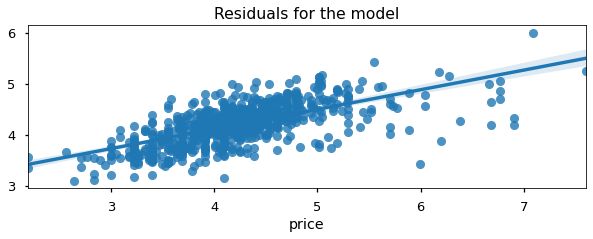

In [124]:
forest_reg(clean_encoded)

In [110]:
#THIS PART HAS BEEN ELIMINATED BECAUSE I'VE REREAD THE DOCUMENTATION FOR THE TREE AND NOW 
#I WOULD OPT FOR PERMUTATION IMPORTANCE (rather than feature importance)

#AS FEATURE IMPORTANCE SUFFERS FROM A BIAS GIVEN BY THE UNDERLYING PROCEDURE OF THE CART TREE 
#THAT FAVOURS VARIABLES THAT OFFER MORE SPLIT IN THE CONSTRUCTION OF THE TREE
#(with continuous variables more or less on the same scale or categorical variables with about the same n° of levels
#would work fine but in this case it would not 
#- that's why calculated host listings count was so high in the ranking)

In [127]:
#feature_importances = grid_search.best_estimator_.feature_importances_
#attributes = X.columns
#features = sorted(zip(feature_importances, attributes), reverse=True)

#Create list of all attributes and their coefficient for plotting purposes
#attribute = []
#coefficient = []
#for feature in features:
#    attribute.append(feature[1]) 
#    coefficient.append(feature[0])
    
#plt.figure(figsize=(10,8))
#plt.bar(attribute[:20], height=coefficient[:20])
#plt.xticks(rotation=90)
#plt.xlabel('feature')
#plt.ylabel('feature importance')
#plt.title('feature importance for the top 20 features')
#plt.show()

In [ ]:
#These are the 20 features that most affect the price according to our random forest model:
#- calculated_host_listings_count and number_of_reviews -> how much one can trust the host
#- availability_90 -> if it's available in the dates I need
#- then follows features about the setup -> meaning if it's the type of property I am looking for and has the setup (n° of bedrooms, bathrooms, etc) I would like to have (most important single private room)
#- then if the reviews are recent -> so I caan trust that the judgements are updated 

#and so on

In [128]:
#plt.figure(figsize=(10,8))
#plt.bar(attribute[-20:], height=coefficient[-20:])
#plt.xticks(rotation=90)
#plt.xlabel('feature')
#plt.ylabel('feature importance')
#plt.title('feature importance for the last 20 features')
#plt.show()

In [125]:
#These, instead, are the features that least affect the price:
#- carport and other particular amenities offered (BBQ, music_tools, etc)
#- whether the host has the profile pic

#and so on

## Which amenities ?
To understand which amenities to include in the listing, here the median price of listings with and without the amenity (and count them to assess popularity) is plot. When the median price for the listings having that amenity is higher than those without, then we can reasonably conclude that the amenity helps potential hosts in increaasing the price. 

In [70]:
#conn = sqlite3.connect(DB_PATH)
#clean_notencoded = pf.read_sql("SELECT * FROM df_clean_notencoded", conn)
#conn.close()

#don't need this because df is defined in the whole environment

In [125]:
def binary_count_and_price_plot_amenities(df, col, figsize=(8,3)):
    """
    counts the number of occurrence of T/F in the specified col of the df and plots a bar chart  
    for each of the two categories records the median price associated and plots the barchart
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col , fontsize=18, y=1)
    plt.subplots_adjust(top=0.70) 
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (€)')
    ax2.set_xlabel('')
    
    sns.despine()
    
    plt.show()

In [126]:
lst_amen = ['high_end_tv','TV','internet','smartworking_tools','music_tools',
            
            'autonomous_checkin','carport','free_parking','paid_parking','long_term_stays','luggage_dropoff',
            'security','breakfast_included','host_greetings',

            'kitchen','freezer','eating_basics','dishwasher','microwave','refrigerator','BBQ','stove',
            'induction_stove','high_end_domesticappliances','oven','coffee_appliances',

            'washing_essentials','bathtub','hair_dryer','washer',

            'bed_extras',

            'indoor_fireplace','privacy','baby_services','pets_allowed','gym','first_aid_kit',
            'elevator','outdoor_spaces','fire_precautions','single_level_home',
            'minifridge','dryer','iron','trash_compactor','air_conditioning','other_cooling_tools']

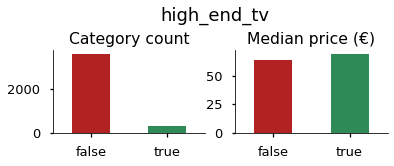

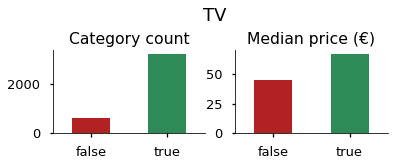

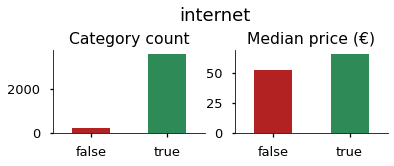

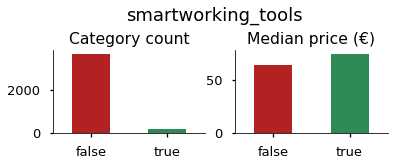

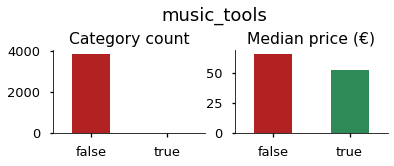

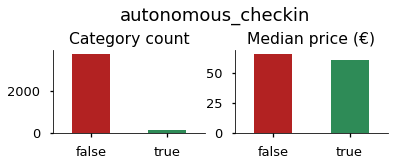

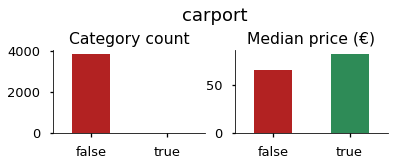

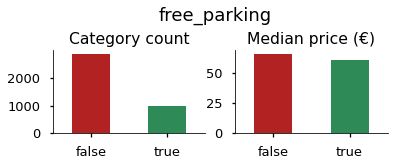

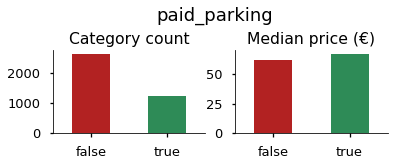

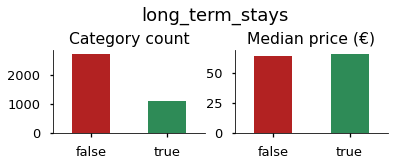

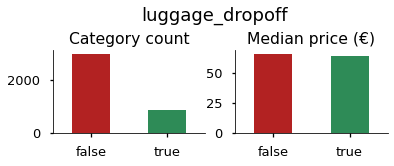

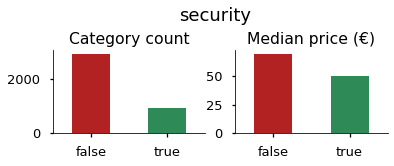

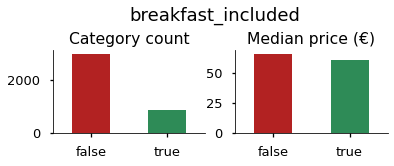

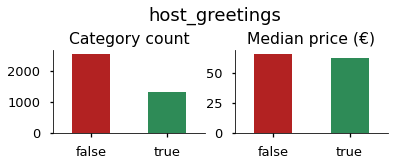

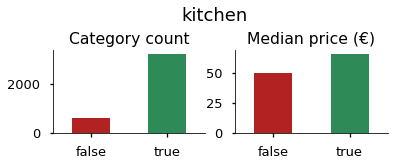

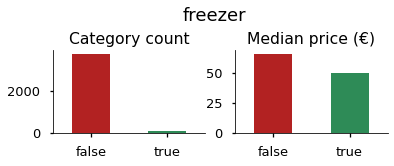

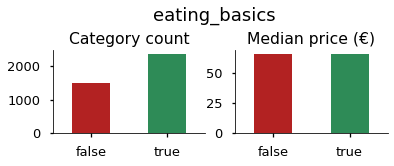

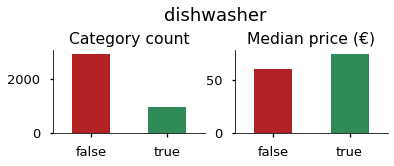

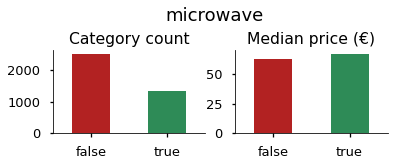

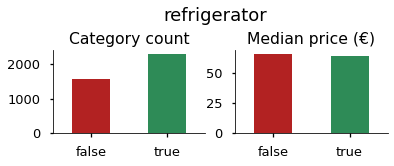

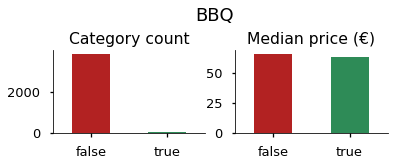

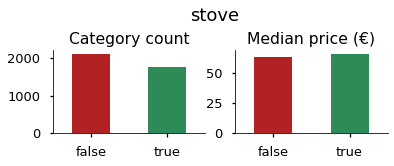

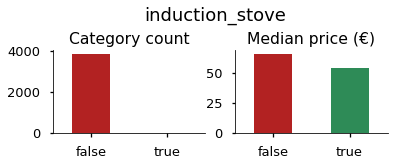

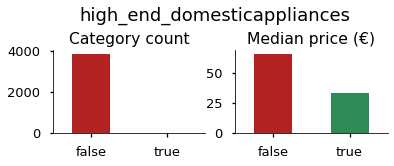

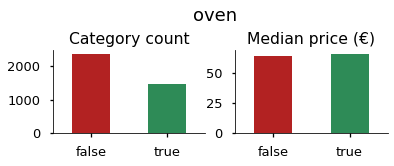

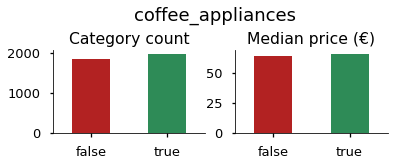

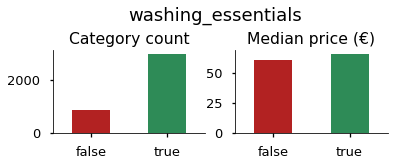

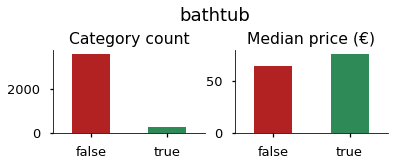

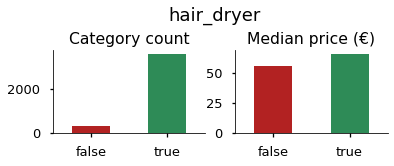

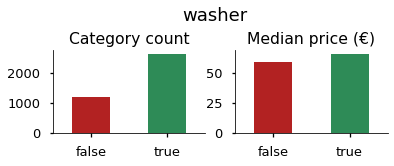

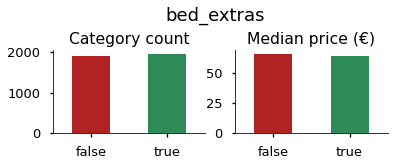

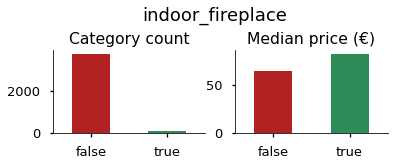

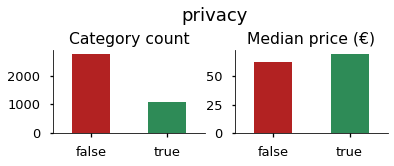

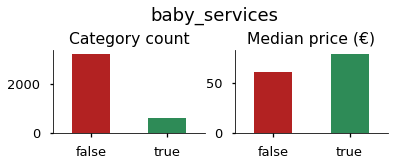

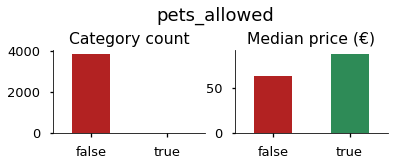

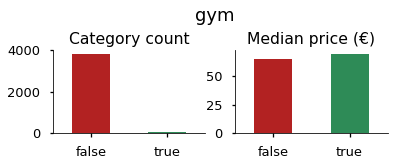

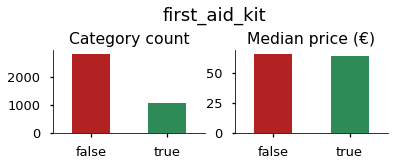

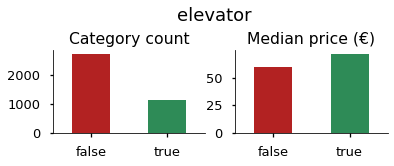

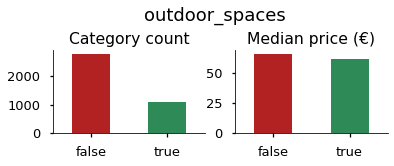

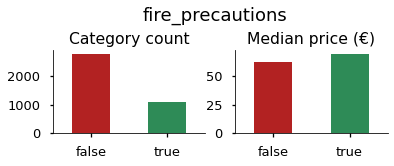

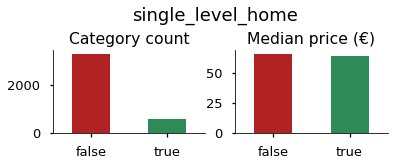

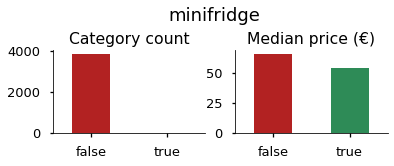

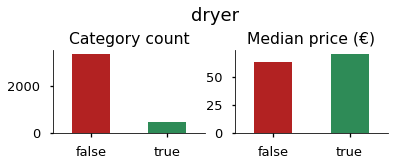

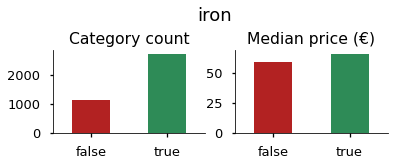

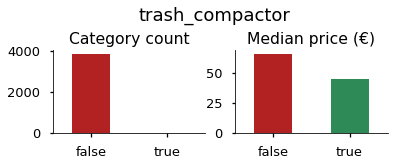

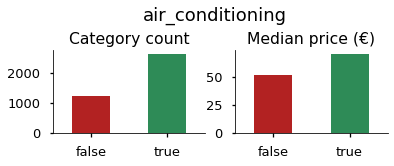

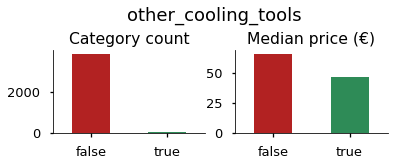

In [127]:
for col in lst_amen:
    binary_count_and_price_plot_amenities(df, col, figsize=(6,2))

> **Bottom line for potential host**: 
> - no amenity disrupts the price setting (location, setup and trustability of the reviews seems to be those thaat most affect the price). In fact, regardless the amenity being observed, the price is always more or less the same value
> - However, the amenities can be divided in 3 categories: 
    > 1. *BASICS*: not having them pushes the price down (median as benchmark) - these are TV, Internet, air conditioning and kitchen
    > 2. *COMMON BUT INCREASING PRICE*: smartworking tools, washer, iron e hairdryer 
    > 3. *UNCOMMON* (the increase in price can be slight or relatively more significant but by virtue of being rare is still an amenity that you might be interested to have, if any just to differentiate the listing): offering baby services, long term stays, microwave, dishwasher, dryer, privacy, luggage dropoff, paid parking 

Note: nightly price median is 65

## Is it worth being superhost? Is it worth being verified
Same reasoning is followed to understand if being such hosts is worth it. If the median price is higher for superhost/verified then we can conclude that there is enough evidence to support becoming a superhost/verified host

In [128]:
def check_superhost_verified(df, col, figsize=(8,3)):
    """
    counts the number of occurrence of T/F in the specified col of the df and plots a bar chart  
    for each of the two categories records the median price associated and plots the barchart
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Is it worth to be '+col[-9:].replace('_','')+'?', fontsize=20, y=1)
    plt.subplots_adjust(top=0.65) 
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count \n')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (€) \n')
    ax2.set_xlabel('')
    
    sns.despine()
    
    plt.show()

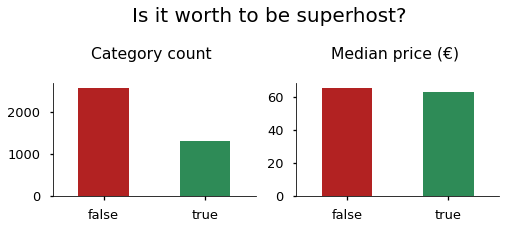

In [129]:
check_superhost_verified(df,'host_is_superhost')

The non superhosts are about twice the number of the superhosts so there are not many superhosts but the price charged by superhosts seems to not be that much higher (though this doesn't tell anything about the frequency of the booking because maybe being superhost makes you more trustworthy and so price being equal you can obtain more bookings so eventually more profit - with data about the actual bookings one could check better if it's worth it - or could define some measure that merges the price and the review but in the interest of time this will work)

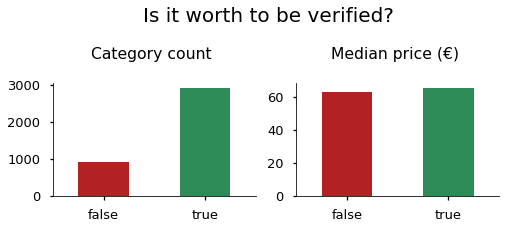

In [130]:
check_superhost_verified(df,'host_identity_verified')

The price for verified is slightly higher than non verified, though it seems to be like a standard so it's more about charging less if not verified 

Note:

Verified host = one whose online identity is consistent with the offline identification (personal ID verified)

Superhost = particular status of excellence among hosts 